In [15]:
import pandas as pd
import numpy as np
import collections
import re
from ast import literal_eval
import itertools
import string
from functools import reduce
from datetime import datetime
import pickle

# import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [16]:
 # read in data
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')
train_data = pd.read_csv('train.csv', na_values=["", "#N/A", "[]", "0"])
test_data = pd.read_csv('test.csv', na_values=["", "#N/A", "[]", "0"])
full_data = pd.concat([train_data, test_data], ignore_index=True)
# headers of columns that show json format data but are currently saved as data type string
na_headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']


In [17]:
# define function to convert string format into json/dict format
def text_to_dict(data, cols):
    '''
    Function to convert string format into dict and list format
    Args: data = dataframe
          cols = list; header names
    Returns: data = dataframe
    '''
    for column in cols:
        data[column] = data[column].apply(lambda x: {} if pd.isna(x) else literal_eval(x))
    return data

# converting all applicable columns to their literal data formats
train = text_to_dict(train, na_headers)
test = text_to_dict(test, na_headers)



In [18]:
def list_breakdown(data, header):
    '''
    Function to breakup the dictionary variable and save the value for
    'name' in a list
    Args: data = dataframe
          header = string; column header
    Returns: all_list = list; values for 'name'
    '''
    
    all_list = {}
    all_list = {i['name'] for row in data[header] for i in row if row != {}}
    
    return sorted(all_list)
                       

In [19]:
# create lists with all possible data points for the 8 dictionary variables
all_keywords = list_breakdown(train, 'Keywords')
all_cast = list_breakdown(train, 'cast')
all_crew = list_breakdown(train, 'crew')
all_lang = list_breakdown(train, 'spoken_languages')
all_product_comp = list_breakdown(train, 'production_companies')
all_product_count = list_breakdown(train, 'production_countries')
all_genres = list_breakdown(train, 'genres')
all_collections = list_breakdown(train, 'belongs_to_collection')

In [20]:
# replace dictionaries by lists with only names for all variables in na_headers
na_headers = pd.Series(na_headers)

def formatting_dict_vars(dataset, headers):
    '''
    Function to turn values of dictionary variables into lists of the value of 'name'
    Args: dataset = dataframe
          headers = list; column headers whose contents need to be transformed
    Returns: dataset = dataframe
    '''
    # create temporary columns
    temp_names = list(map(lambda x: x+'_temp', headers))
    for header in temp_names:
        dataset[header] = 0
    
    # transform dicts into lists containing only the names
    j = 0
    for org_header in headers:
        dataset[temp_names[j]] = dataset[org_header].apply(lambda x: ','.join([i['name'] for i in x]) if x != {} else '')
        j += 1
        
    return dataset

train = formatting_dict_vars(train, na_headers)
test = formatting_dict_vars(test, na_headers)

####Hello

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']


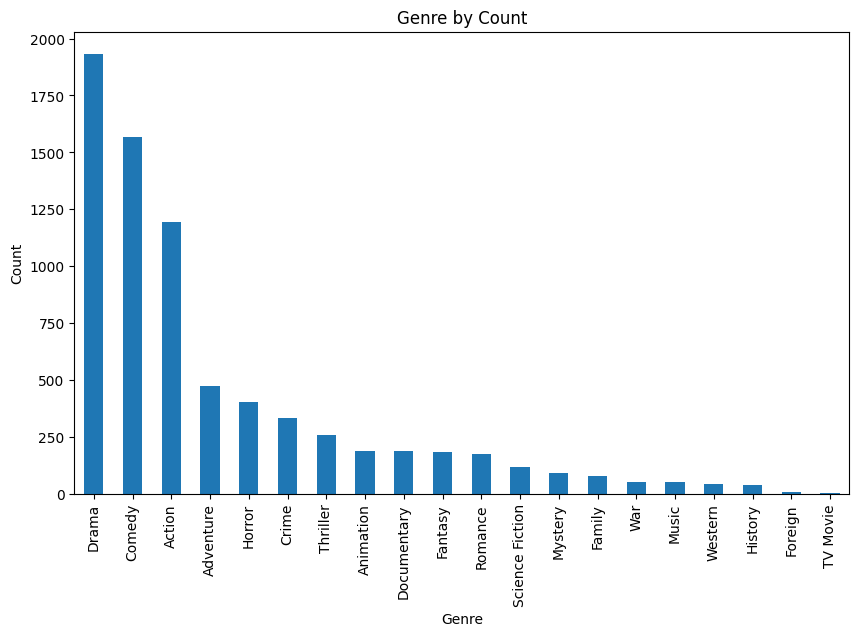

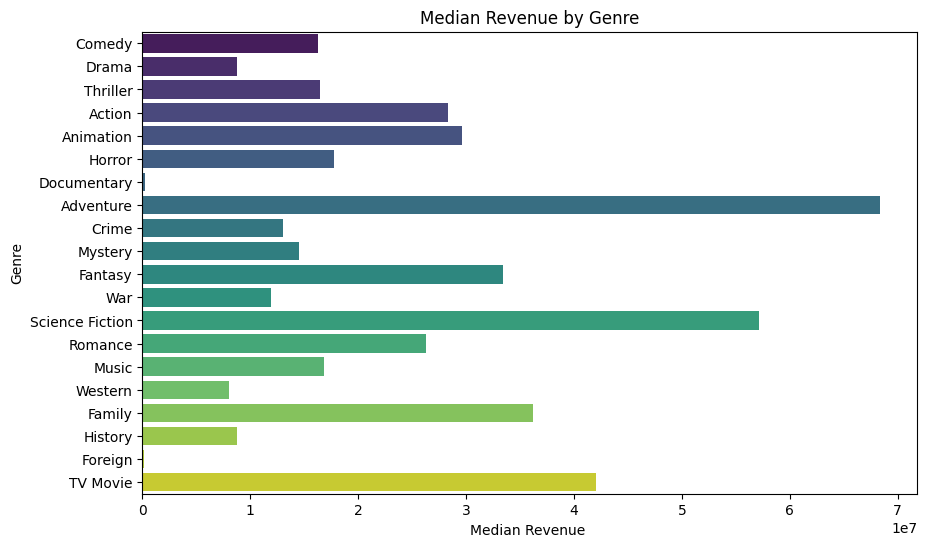

In [21]:
# Trích xuất thể loại phim chính từ cột 'genres' và gán vào cột 'main_genre'
print(all_genres)
genres_matching_point = '|'.join(all_genres)
full_data['main_genre'] = full_data['genres'].str.extract(fr'({genres_matching_point})')
# Tạo biểu đồ bar plot thể hiện số lượng phim theo từng thể loại chính
plt.figure(figsize=(10, 6))
genre_counts = full_data['main_genre'].value_counts().head(20)  # Lấy 20 thể loại phim phổ biến nhất
genre_counts.plot(kind='bar')

# Thiết lập tiêu đề và nhãn trục
plt.title('Genre by Count')
plt.xlabel('Genre')
plt.ylabel('Count')

# Hiển thị biểu đồ
plt.show()
subset_data = full_data.iloc[:3000]

# Tạo biểu đồ bar plot thể hiện doanh thu trung vị theo từng thể loại chính
plt.figure(figsize=(10, 6))
sb.barplot(data=subset_data, x='revenue', y='main_genre', hue='main_genre', estimator=np.median, errorbar=None, palette='viridis', legend=False)

# Cấu hình trục y
# plt.xticks([0, 25000000, 50000000, 70000000], ['$0', '$25', '$50', '$70'])  # Thay đổi nhãn trục x

# Thiết lập tiêu đề và nhãn trục
plt.title('Median Revenue by Genre')
plt.ylabel('Genre')  # Thay đổi nhãn trục y
plt.xlabel('Median Revenue ')  # Thay đổi nhãn trục x

# Hiển thị biểu đồ
plt.show()


=> Từ những plot trên chúng ta có thể thấy được sử khác biệt giữa doanh số với những thể loại khác nhau. Các thể loại như hành động, phiêu lưu, hoạt hình và khoa học viễn tưởng thường có doanh thu cao hơn so với các thể loại khác

Thông tin về phim No-collection có doanh thu cao nhất:
684    Beauty and the Beast
Name: original_title, dtype: object 684    1.262886e+09
Name: revenue, dtype: float64


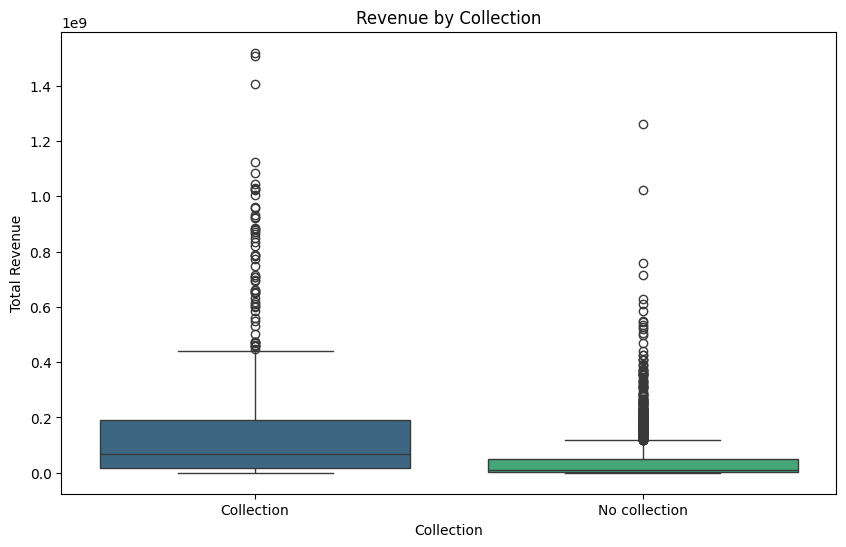

In [22]:
# Trích xuất thông tin về tên bộ sưu tập từ cột 'belongs_to_collection' và lưu vào cột 'collection_name'
full_data['collection_name'] = full_data['belongs_to_collection'].str.extract(r"'name'\:\s\'(.+?)\'\,\s\'poster'")

# Thống kê số lượng phim trong từng bộ sưu tập và lấy 10 bộ sưu tập phổ biến nhất
top_collections = full_data['collection_name'].value_counts().head(10)

# Thiết lập cột 'collection' dựa trên 'belongs_to_collection'
full_data['collection'] = 'No collection'
full_data.loc[~full_data['belongs_to_collection'].isna(), 'collection'] = 'Collection'

# Vẽ biểu đồ boxplot
plt.figure(figsize=(10, 6))
sb.boxplot(data=full_data.iloc[:3000], x='collection', y='revenue', hue='collection', palette='viridis')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Collection')
plt.xlabel('Collection')
plt.ylabel('Total Revenue')
no_collection_movies = full_data[full_data['collection'] == 'No collection']

# Tìm phim No-collection có doanh thu cao nhất
movie_with_highest_revenue = no_collection_movies[no_collection_movies['revenue'] == no_collection_movies['revenue'].max()]

# In ra thông tin về phim có doanh thu cao nhất trong bộ sưu tập "No collection"
print("Thông tin về phim No-collection có doanh thu cao nhất:")
print(movie_with_highest_revenue['original_title'], movie_with_highest_revenue['revenue'] )

####Dữ liệu cho thấy rằng doanh thu của phim collection movie thường cao hơn đáng kể so với doanh thu của phim no collection movie. Điều này có thể là do một số yếu tố, bao gồm:
- Sự quan tâm của người hâm mộ. Phim collection movie thường dựa trên các thương hiệu nổi tiếng hoặc các loạt phim ăn khách, vì vậy chúng thường thu hút nhiều người hâm mộ.
- Độ hấp dẫn của nội dung. Phim collection movie thường được đầu tư kỹ lưỡng hơn về mặt nội dung và hình ảnh, vì vậy chúng thường mang lại trải nghiệm xem hấp dẫn hơn.
- Chiến lược tiếp thị và phân phối. Phim collection movie thường được tiếp thị và phân phối rộng rãi hơn, vì vậy chúng có thể tiếp cận được với nhiều khán giả hơn.

####Tuy nhiên, cũng có một số trường hợp phim no collection movie có doanh thu cao hơn phim collection movie. Điều này có thể là do một số yếu tố, bao gồm:
- Sự nổi tiếng của đạo diễn hoặc diễn viên. Nếu phim có sự tham gia của đạo diễn hoặc diễn viên nổi tiếng, nó có thể thu hút nhiều khán giả dù không có thương hiệu hay nội dung hấp dẫn.
- Chiến lược tiếp thị sáng tạo. Nếu phim có chiến lược tiếp thị sáng tạo, nó có thể thu hút sự chú ý của khán giả và giúp tăng doanh thu.
Xu hướng thị trường. Nếu thị trường có xu hướng ưa chuộng các thể loại phim khác nhau, phim no collection movie có thể được hưởng lợi từ xu hướng này.

In [23]:
def total_count(data, header, topk=30):
    '''
    Function to return the topk results and the number of their occurence in the data set
    Args: data = dataframe
          header = string; column header
          topk = int; default is 30; amount of top results to be displayed
    Returns: total =  list of dictionaries
    '''
    every_mention = list(i['name'] for row in data[header] for i in row if row != {})
    total = collections.Counter(every_mention).most_common(topk)
    return total
counter = 0
top_prod_comps = []
for item in total_count(train, 'production_companies'):
    if counter == 15:
        break
    else:
        header_name = str(item[0])+'_prod'
        train[header_name] = train['production_companies_temp'].apply(lambda x: 1 if item[0] in x else 0)
        top_prod_comps.append(item[0])
    counter += 1
print(top_prod_comps)

['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'TriStar Pictures', 'Relativity Media', 'Canal+', 'United Artists', 'Miramax Films']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


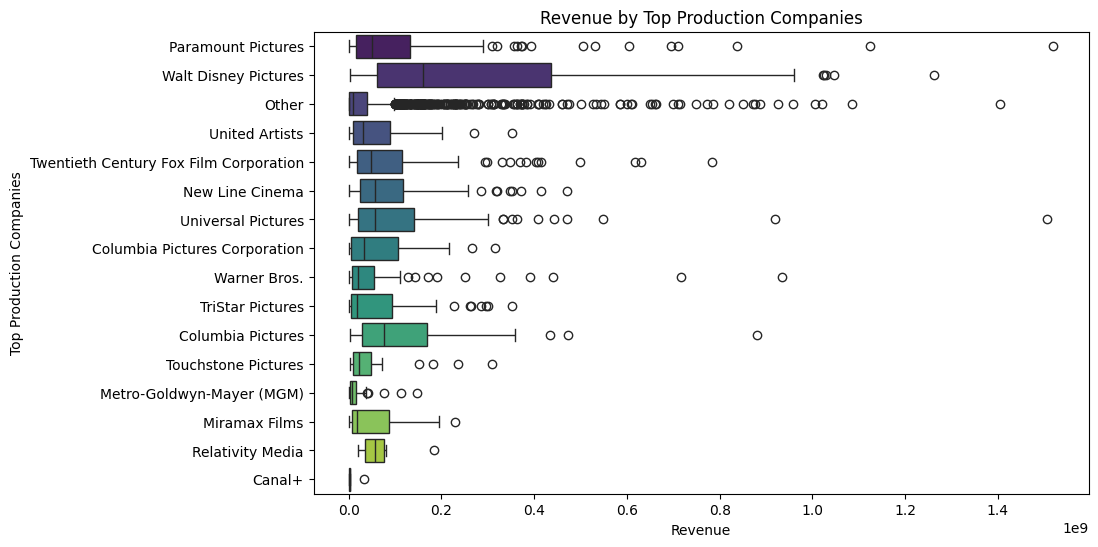

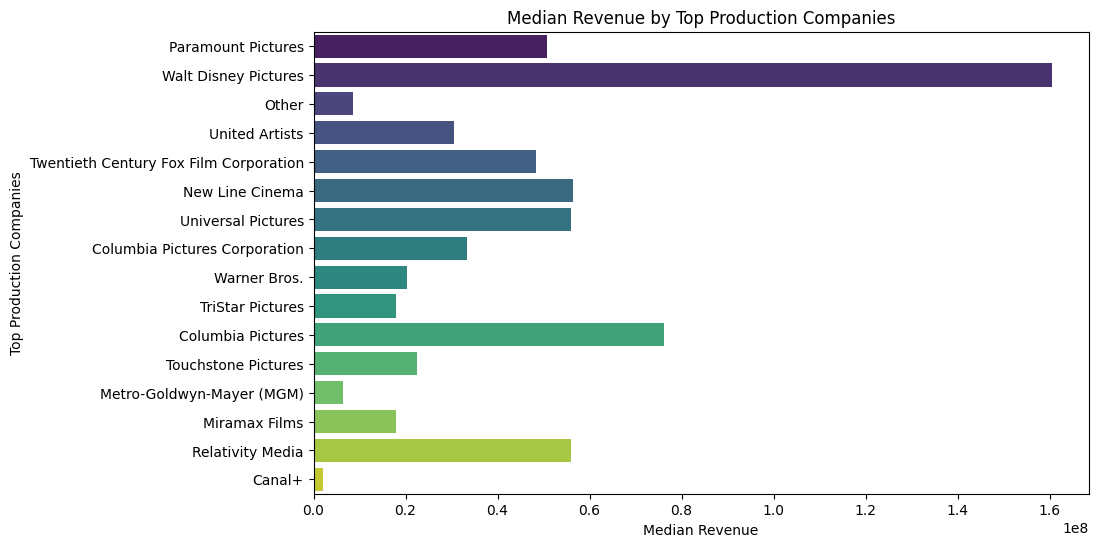

In [24]:
full_data['prod_comp_name'] = full_data['production_companies'].str.replace(r"(^\[\{'name'\:\s\'|\',\s\'id.*)", '', regex=True)

# Tạo danh sách các công ty sản xuất hàng đầu và gán nhãn 'Other' cho các công ty không nằm trong danh sách


full_data['top_prod_comp'] = full_data['prod_comp_name'].where(full_data['prod_comp_name'].isin(top_prod_comps), other='Other')

# Vẽ biểu đồ boxplot
plt.figure(figsize=(10, 6))
sb.boxplot(data=full_data.iloc[:3000], x='revenue', y='top_prod_comp', hue='top_prod_comp', palette='viridis')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0M', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Top Production Companies')
plt.xlabel('Revenue')
plt.ylabel('Top Production Companies')

# Loại bỏ chú thích
plt.legend().remove()

# Hiển thị biểu đồ
plt.show()
subset_data = full_data.iloc[:3000]

# Tạo biểu đồ bar plot thể hiện doanh thu trung vị theo từng công ty sản xuất hàng đầu
plt.figure(figsize=(10, 6))
sb.barplot(data=subset_data, x='revenue', y='top_prod_comp', estimator=np.median, errorbar=None, hue='top_prod_comp', palette='viridis', legend=False)

# Cấu hình trục y
# plt.yticks([0, 50000000, 100000000, 150000000], ['$0', '$50', '$100', '$150'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Median Revenue by Top Production Companies')
plt.xlabel('Median Revenue')
plt.ylabel('Top Production Companies')

# Hiển thị biểu đồ
plt.show()

=> Nhìn vào biểu đồ chúng ta thấy số lượng bộ phim đến từ những công ty lớn có độ nhất diện cao thường có doanh thu trung bình cao hơn những công ty sản xuất nhỏ lẻ khác

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


prod_country
US    4492
GB     548
FR     350
CA     267
DE     224
IN     204
AU     123
JP     122
RU     114
ES      85
Name: count, dtype: int64


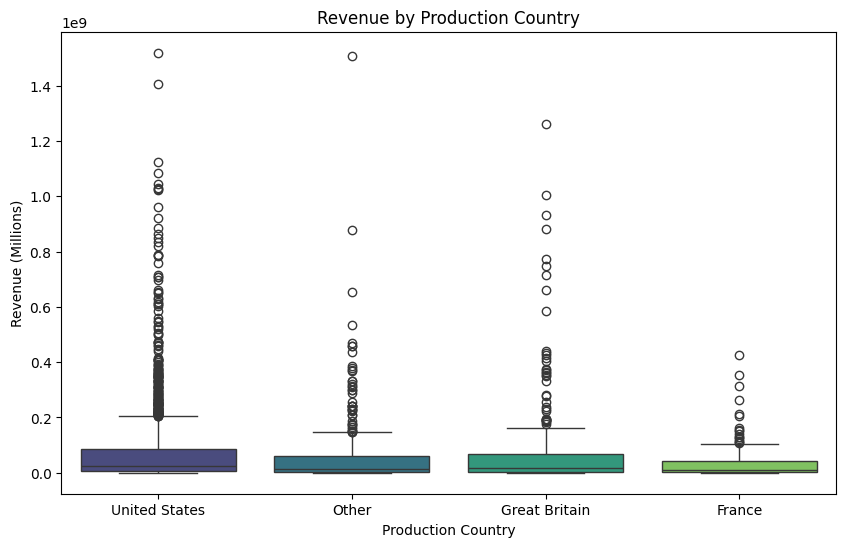

C:\Users\admin\AppData\Local\Temp\ipykernel_26932\3149608794.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sb.barplot(data=full_data_selected.head(3000), x='top_prod_country', y='revenue', estimator=pd.Series.median, ci=None, palette='viridis')
C:\Users\admin\AppData\Local\Temp\ipykernel_26932\3149608794.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(data=full_data_selected.head(3000), x='top_prod_country', y='revenue', estimator=pd.Series.median, ci=None, palette='viridis')


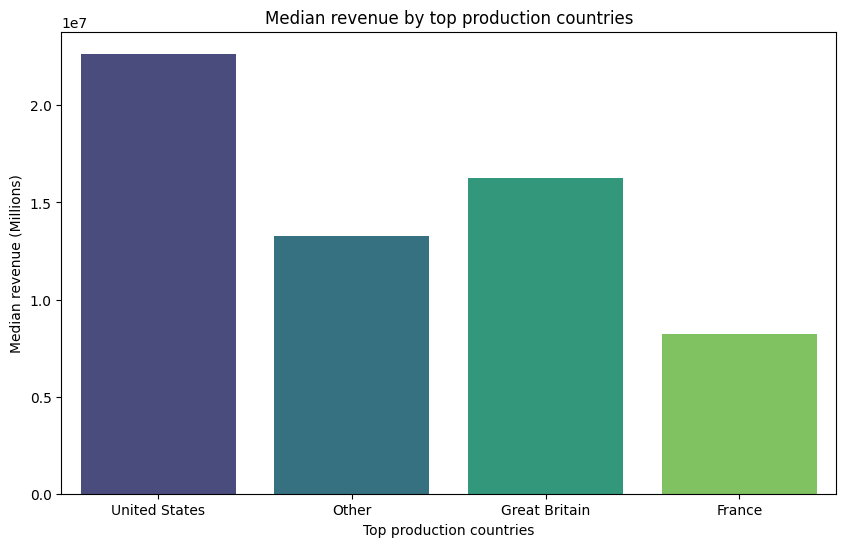

In [25]:
# Trích xuất mã quốc gia từ cột 'production_countries'
full_data['prod_country'] = full_data['production_countries'].str.extract(r'([A-Z]+)')

# Thống kê số lượng phim theo quốc gia sản xuất hàng đầu và chọn 10 quốc gia
top_countries = full_data['prod_country'].value_counts().head(10)
print(top_countries)

# Chuyển đổi các mã quốc gia thành tên quốc gia tương ứng
full_data['top_prod_country'] = full_data['prod_country'].replace({
    'US': 'United States',
    'GB': 'Great Britain',
    'FR': 'France'
})

# Gán nhãn 'Other' cho các quốc gia không nằm trong danh sách trên hoặc NaN
countries_to_replace = ['CA', 'DE', 'IN', 'AU', 'JP', 'RU', 'ES']  # Danh sách mã quốc gia cần thay thế

# Thực hiện việc thay thế giá trị trong cột 'top_prod_country'
full_data.loc[full_data['top_prod_country'].isin(countries_to_replace), 'top_prod_country'] = 'Other'

# Lọc dữ liệu để chỉ bao gồm 4 quốc gia US, GB, FR, Other
selected_countries = ['United States', 'Great Britain', 'France', 'Other']
full_data_selected = full_data[full_data['top_prod_country'].isin(selected_countries)]
# Vẽ biểu đồ boxplot
plt.figure(figsize=(10, 6))
sb.boxplot(data=full_data_selected.head(3000), x='top_prod_country', y='revenue', hue='top_prod_country', palette='viridis')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Production Country')
plt.xlabel('Production Country')
plt.ylabel('Revenue (Millions)')

# Loại bỏ chú thích
plt.legend().remove()

# Hiển thị biểu đồ
plt.show()
# subset_data = full_data.iloc[:3000]

# Vẽ biểu đồ bar plot với giá trị trung vị (median) theo từng quốc gia sản xuất hàng đầu
plt.figure(figsize=(10, 6))
sb.barplot(data=full_data_selected.head(3000), x='top_prod_country', y='revenue', estimator=pd.Series.median, ci=None, palette='viridis')

# Cấu hình trục y
# plt.yticks([0, 10000000, 20000000], ['$0', '$10', '$20'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Median revenue by top production countries')
plt.xlabel('Top production countries')
plt.ylabel('Median revenue (Millions)')

# Hiển thị biểu đồ
plt.show()
# other_country_movies = full_data[(full_data['top_prod_country'] == 'Other') & (~full_data['revenue'].isnull())]

# # Tìm phim ở quốc gia 'Other' có doanh thu cao nhất
# movie_highest_revenue_other = other_country_movies[other_country_movies['revenue'] == other_country_movies['revenue'].max()]

# # In ra thông tin về phim ở quốc gia 'Other' có doanh thu cao nhất
# print("Thông tin về phim sản xuất ở quốc gia 'Other' có doanh thu cao nhất:")
# print(movie_highest_revenue_other)

C:\Users\admin\AppData\Local\Temp\ipykernel_26932\1152868754.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'English' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_data.loc[train_data['original_language'] == 'en', 'language'] = 'English'


original_language
en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
Name: count, dtype: int64


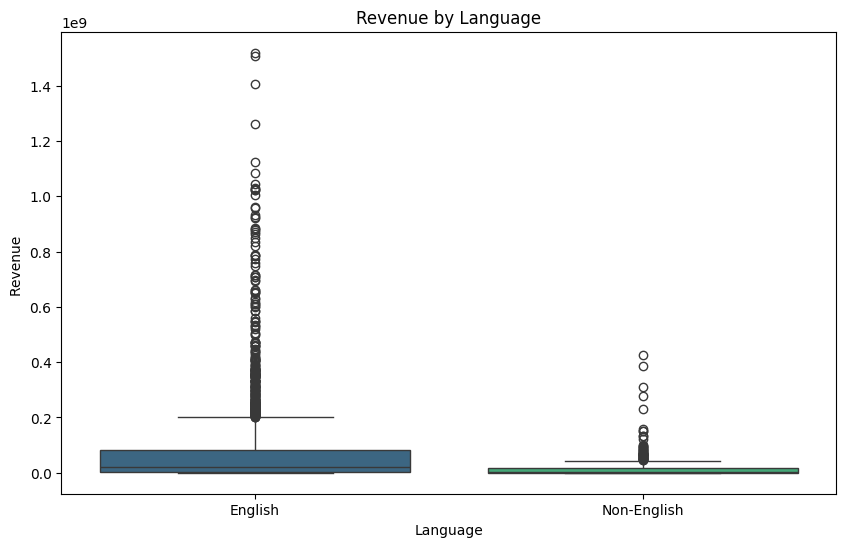

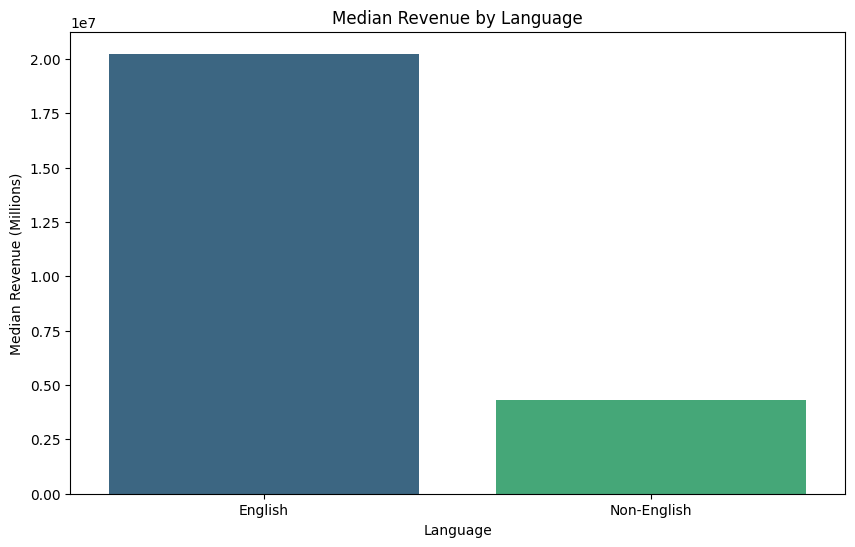

In [26]:
# Thực hiện nhóm dữ liệu theo ngôn ngữ gốc và thống kê số lượng phim
language_counts = train_data['original_language'].value_counts().head(10)
print(language_counts)

# Chuyển các phim tiếng Anh và các phim không có thông tin ngôn ngữ thành 'English' và 'Non-English' tương ứng
train_data.loc[train_data['original_language'] == 'en', 'language'] = 'English'
train_data['language'].fillna('Non-English', inplace=True)

# Vẽ biểu đồ boxplot
plt.figure(figsize=(10, 6))
sb.boxplot(data=train_data, x='language', y='revenue', hue='language', palette='viridis', legend =True)

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Language')
plt.xlabel('Language')
plt.ylabel('Revenue ')

# Loại bỏ chú thích
plt.legend().remove()

# Hiển thị biểu đồ
plt.show()




# Vẽ biểu đồ barplot với giá trị trung vị theo ngôn ngữ
plt.figure(figsize=(10, 6))
sb.barplot(data=train_data, x='language', y='revenue', hue='language', estimator=pd.Series.median, errorbar=None, palette='viridis', legend=False)

# Cấu hình trục y
# plt.yticks([0, 10000000, 20000000], ['$0', '$10', '$20'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Median Revenue by Language')
plt.xlabel('Language')
plt.ylabel('Median Revenue (Millions)')

# Hiển thị biểu đồ
plt.show()


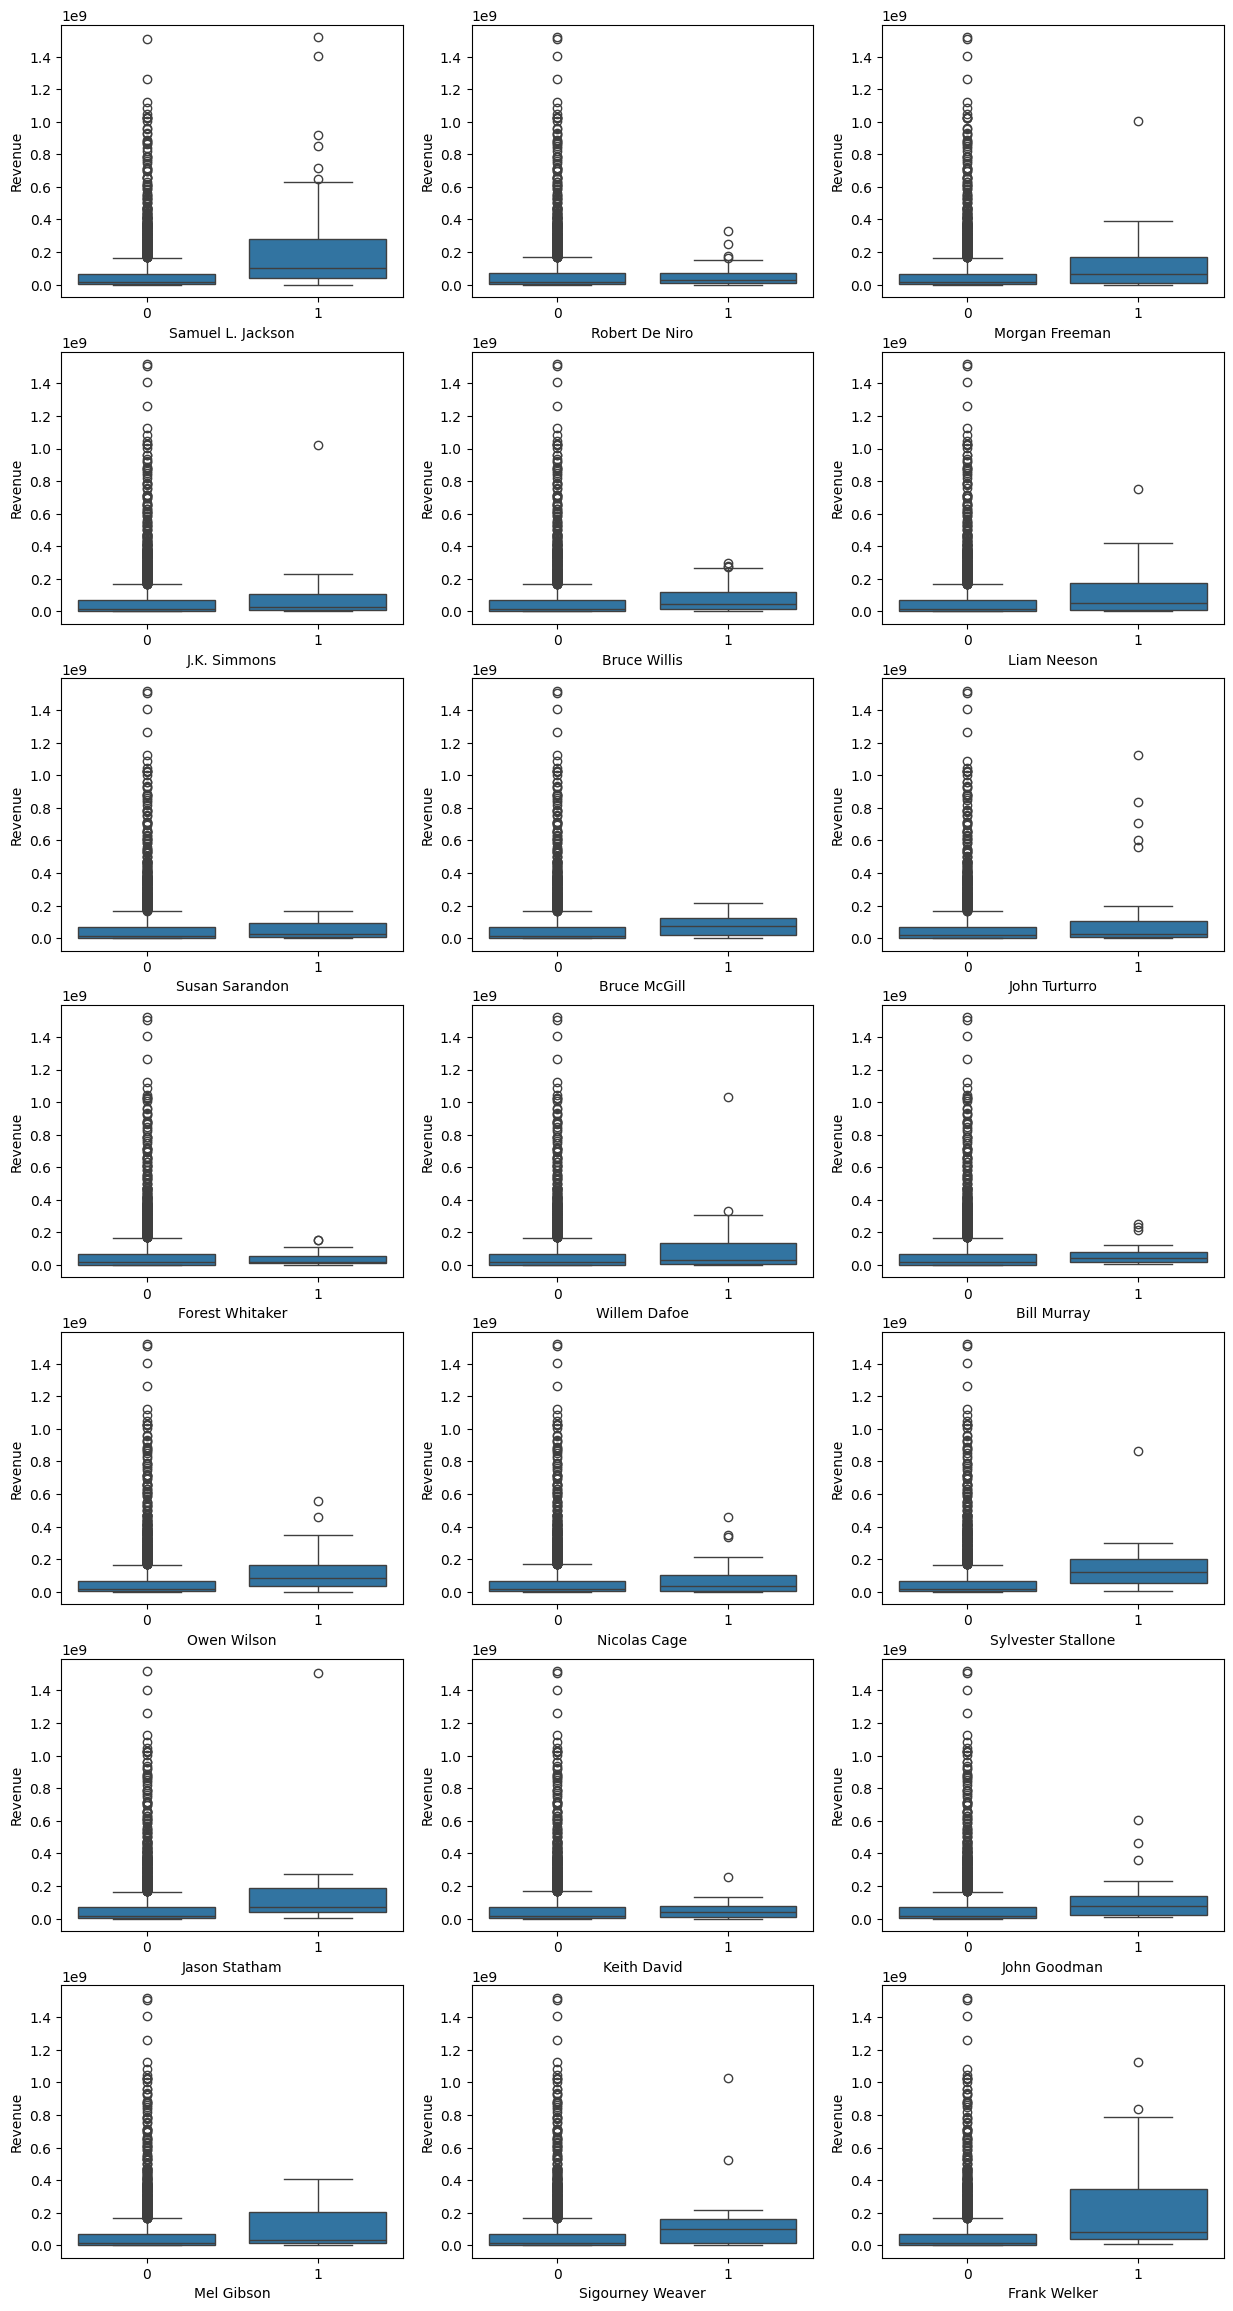

In [27]:
counter = 0
top_cast = []
for item in total_count(train, 'cast'):
    if counter == 21:
        break
    else:
        header_name = str(item[0])+'_name'
        train[header_name] = train['cast_temp'].apply(lambda x: 1 if item[0] in x else 0)
        top_cast.append(item[0])
    counter += 1
# plotting the revenue of the most common actors vs. the rest
fig, ax = plt.subplots(7, 3, figsize = [15, 29])
# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 6 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = train, x = top_cast[counter]+'_name', y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(top_cast[counter])
            counter += 1

['woman director',
 'independent film',
 'duringcreditsstinger',
 'murder',
 'based on novel',
 'violence',
 'sport',
 'biography',
 'aftercreditsstinger',
 'dystopia',
 'revenge',
 'friendship',
 'sex',
 'suspense',
 'sequel',
 'love',
 'police',
 'teenager',
 'nudity',
 'female nudity',
 'drug']

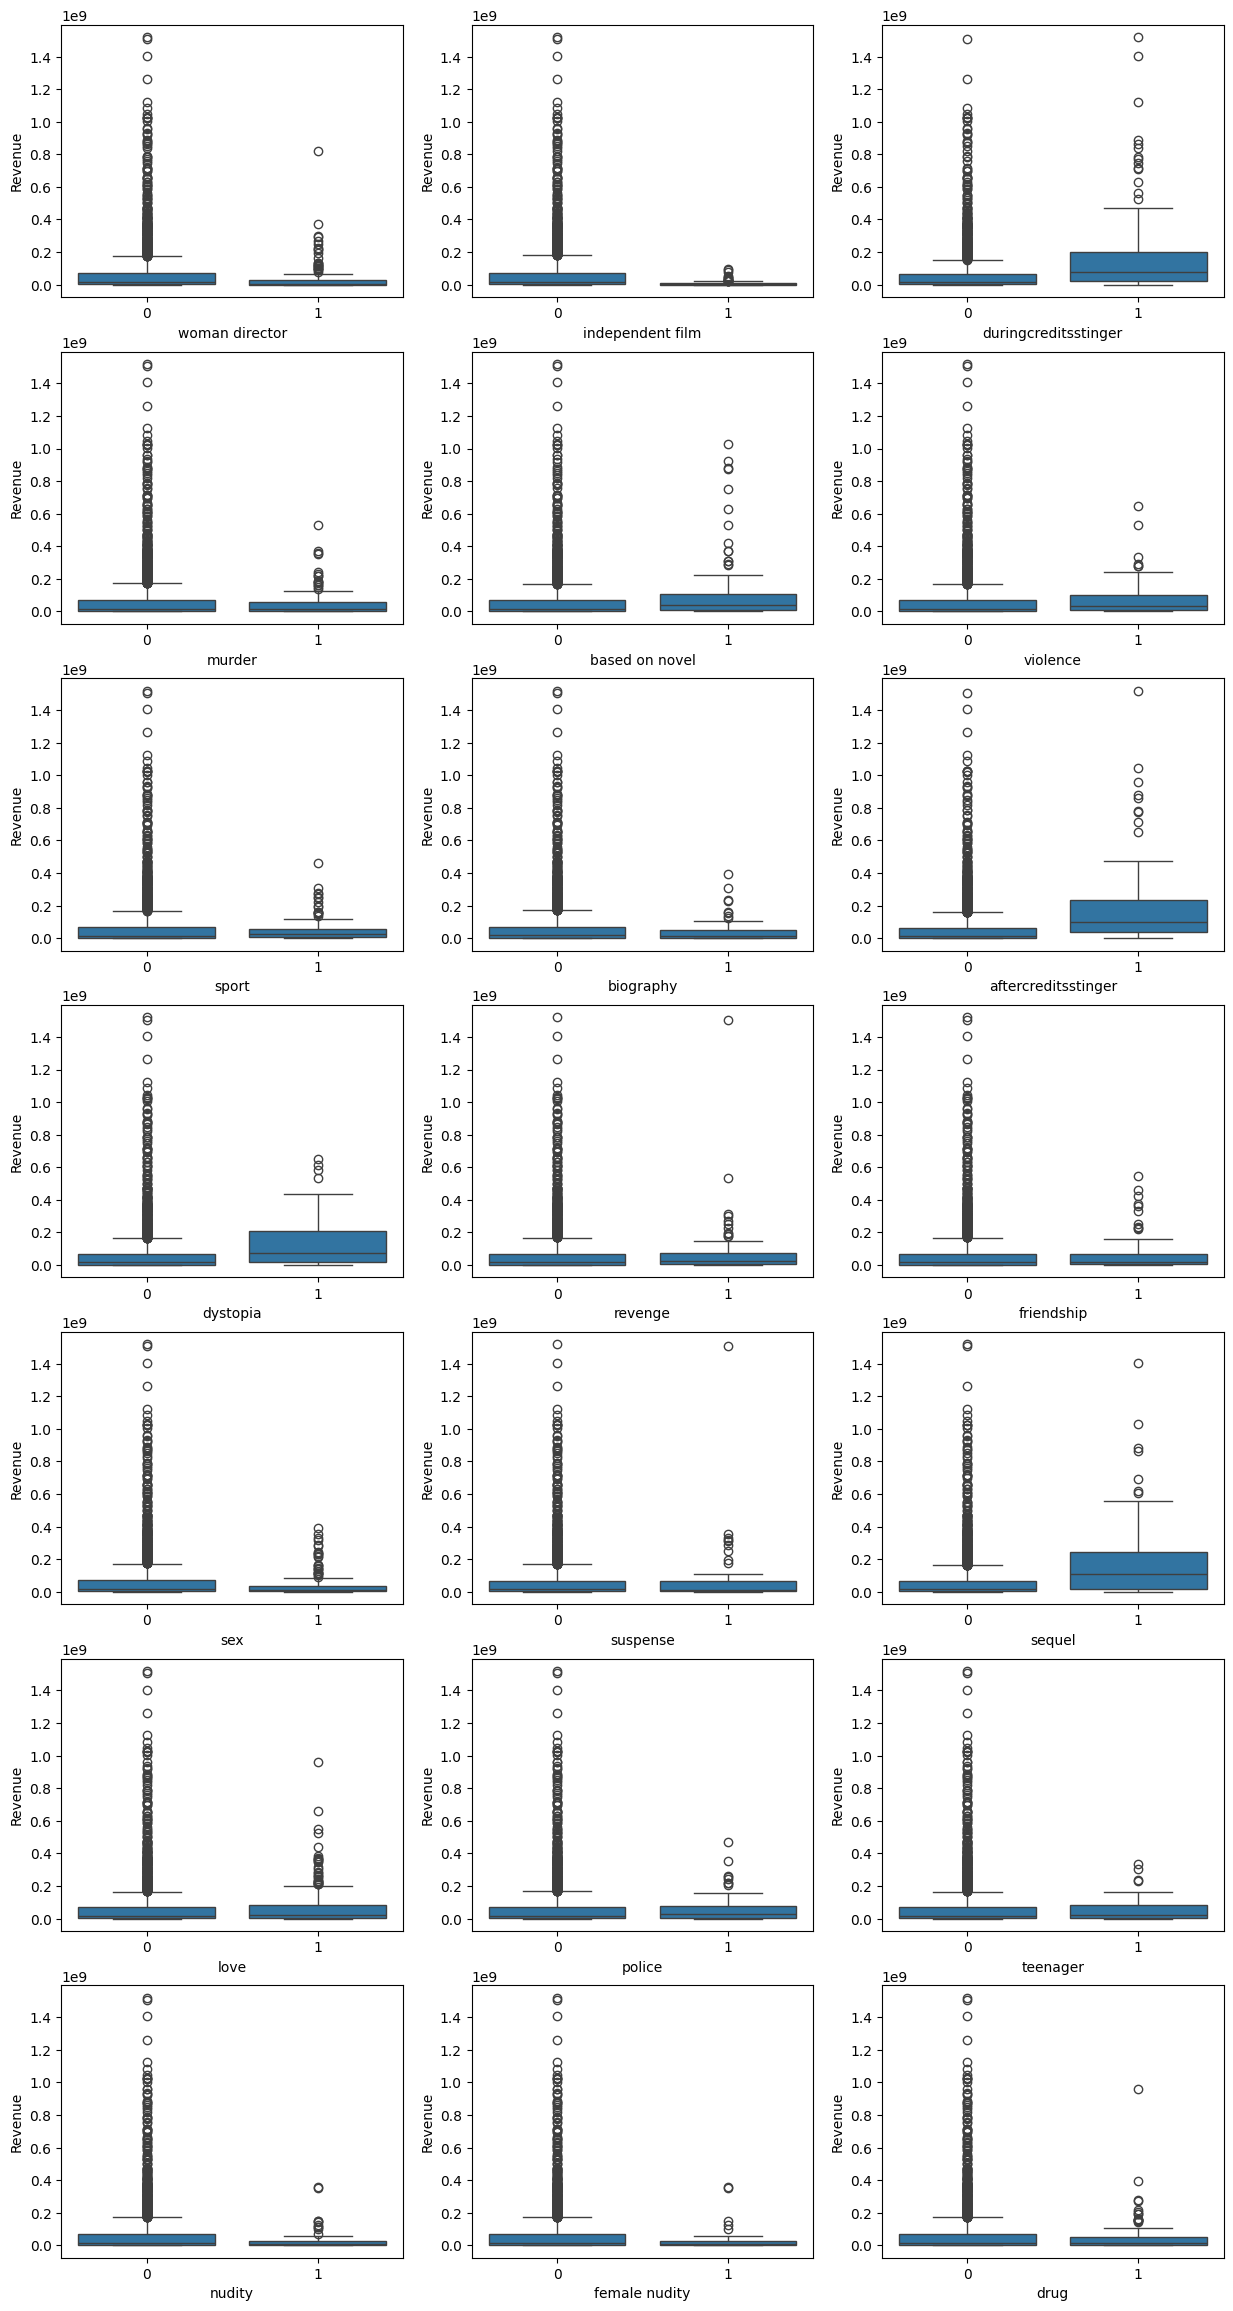

In [28]:
# Function to filter out the 21 most common returns of a feature and plot boxplots for each return on revenue
def filter_and_plot(df, value_name):
    '''
    Function to filter out the 21 most common returns of a feature and plot boxplots for each return and 
    its revenue distribution
    Args: df = dataframe
          value_name = lstring; representing the name of the feature to be investigated 
    Returns: top_list = list of 21 most common
    '''
    
    # Top_k values of a feature
    counter = 0
    top_list = []
    for item in total_count(df, value_name):
        if counter == 21:
            break
        else:
            header_name = str(item[0])+'_name'
            df[header_name] = df[value_name+'_temp'].apply(lambda x: 1 if item[0] in x else 0)
            top_list.append(item[0])
        counter += 1
    
    top_list_name = [x+'_name' for x in top_list]
    
    # plotting the revenue of the most common crew members vs. the rest
    fig, ax = plt.subplots(7, 3, figsize = [15, 29])
    # crew counter
    tracker = 0

    for j in range(len(ax)):
        for i in range(len(ax[j])):
            if j == 6 and i == 3:
                break
            else:
                ax[j][i] = sb.boxplot(data = df, x = top_list[tracker]+'_name', y = 'revenue', ax=ax[j][i])
                ax[j][i].set_ylabel('Revenue')
                ax[j][i].set_xlabel(top_list[tracker])
                tracker += 1


    return top_list
top_value = filter_and_plot(train, 'Keywords')
top_value

0 data entries without original title
188 movies have a title that contains one or more integers


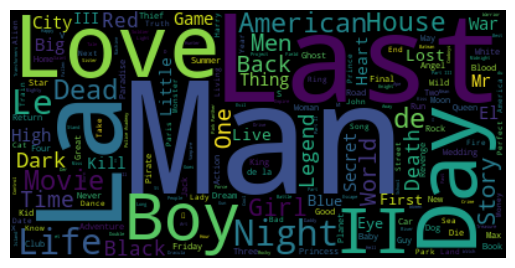

In [29]:
# Exploration original title

# Fill all NAs
missing_val = train['original_title'].isnull().sum()
print(f'{missing_val} data entries without original title')

train['original_title'] = train['original_title'].fillna('None')
test['original_title'] = test['original_title'].fillna('None')

# list all movies that contain numbers
films_with_ints = sorted([title for title in train['original_title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_org_title = train['original_title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_org_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


597 data entries without tagline


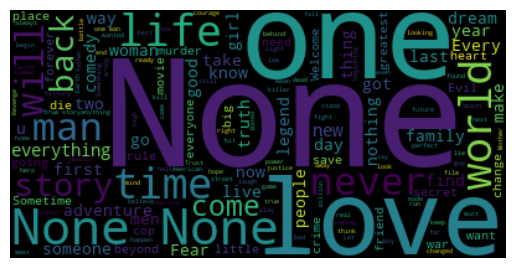

In [30]:
missing_val = train['tagline'].isnull().sum()
print(f'{missing_val} data entries without tagline')

train['tagline'] = train['tagline'].fillna('None')
test['tagline'] = test['tagline'].fillna('None')

# Creating word cloud
all_tagline = train['tagline'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_tagline)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

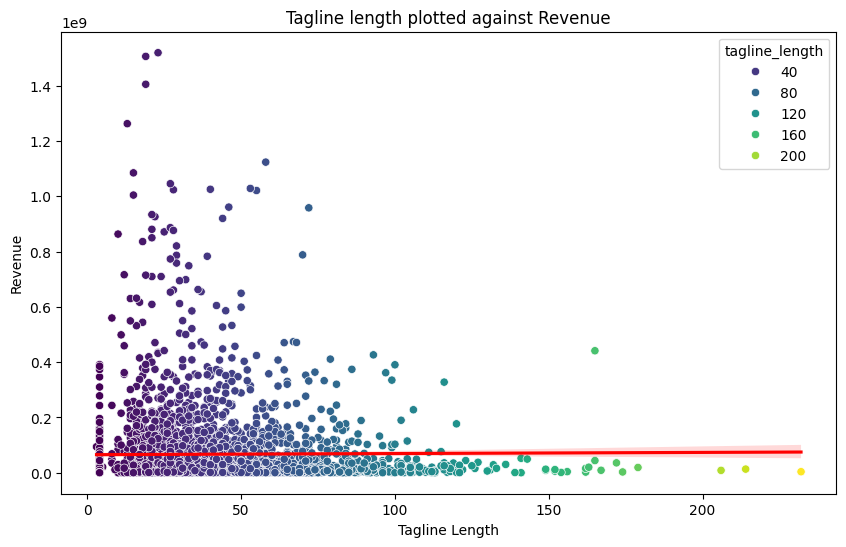

In [33]:
train['tagline_exists'] = train['tagline'].apply(lambda x: 1 if x != 0 else 0)

# Add column for length of tag line
train['tagline'].fillna(0, inplace=True)
train['tagline_length'] = train['tagline'].apply(lambda x: len(x) if x != 0 else 0)
plt.figure(figsize=(10, 6))
# Scatter plot (điểm)
sb.scatterplot(data=train, x='tagline_length', y='revenue', hue='tagline_length', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='tagline_length', y='revenue', scatter=False, color='red', line_kws={"color": "red"}, ci = 95)
plt.xlabel('Tagline Length')
plt.ylabel('Revenue')
plt.title('Tagline length plotted against Revenue');



0 data entries without title
[{'Marine Boy': '마린보이'}, {'Skinning': 'Šišanje'}, {'The Intouchables': 'Intouchables'}, {'The Double Hour': 'La doppia ora'}, {'Moscow, Belgium': 'Aanrijding in Moscou'}]
193 movies have a title that contains one or more integers


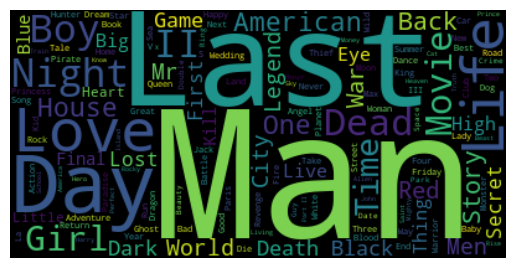

In [26]:
missing_val = train['title'].isnull().sum()
print(f'{missing_val} data entries without title')

train['title'] = train['title'].fillna('None')
test['title'] = test['title'].fillna('None')

v = train['title']
w = train['original_title']

diff_list_title = [{x: y} for x, y in zip(train['title'] , train['original_title']) if x != y]

print(diff_list_title[:5])
films_with_ints = sorted([title for title in train['title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_title = train['title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

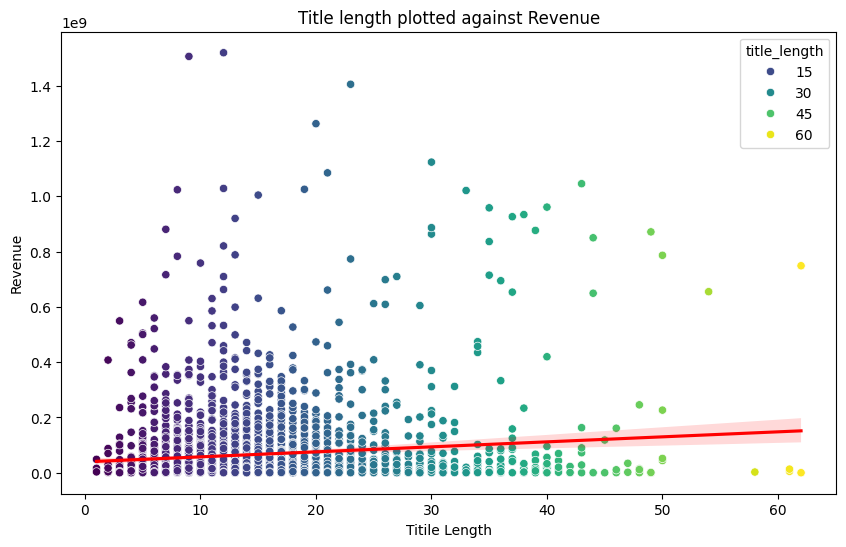

In [27]:
train['title'].fillna(0, inplace=True)
train['title_length'] = train['title'].apply(lambda x: len(x) if x != 0 else 0)
plt.figure(figsize=(10, 6))
# Scatter plot (điểm)
sb.scatterplot(data=train, x='title_length', y='revenue', hue='title_length', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='title_length', y='revenue', scatter=False, color='red', line_kws={"color": "red"}, ci = 95)
plt.xlabel('Titile Length')
plt.ylabel('Revenue')
plt.title('Title length plotted against Revenue');

### Numeric variables


#### budget


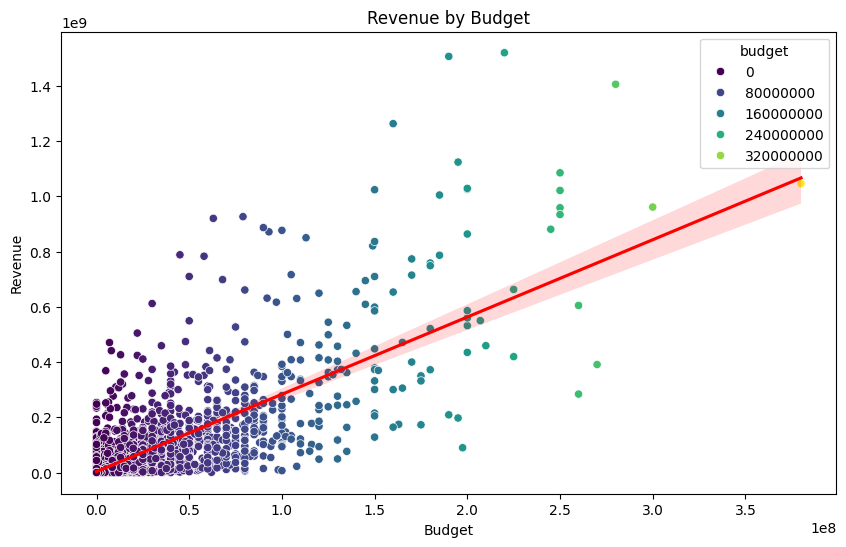

In [28]:
plt.figure(figsize=(10, 6))

# Scatter plot (điểm)
sb.scatterplot(data=train, x='budget', y='revenue', hue='budget', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='budget', y='revenue', scatter=False, color='red', line_kws={"color": "red"}, ci = 95)

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')

# Hiển thị biểu đồ
plt.show()
# highest_revenue_movie = train['revenue'].max()

# # # In tên phim
# print(train[train['revenue'] == highest_revenue_movie]['popularity'].iloc[0])

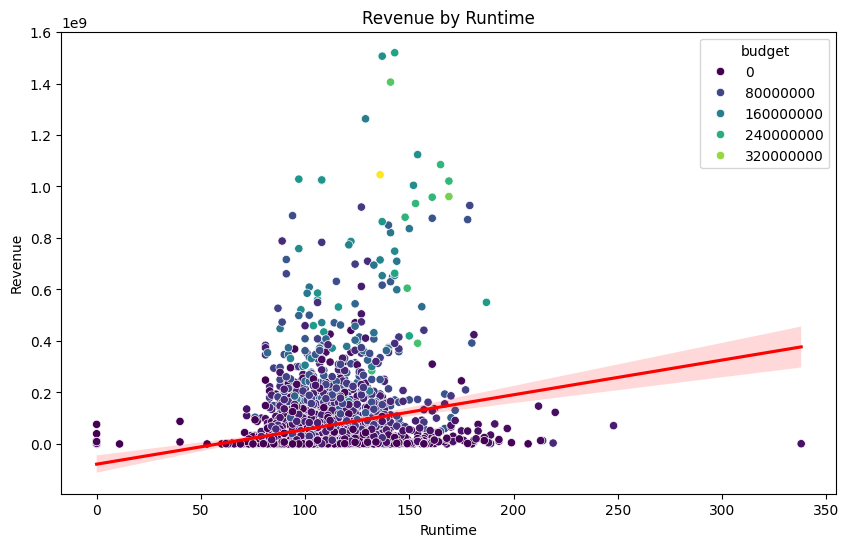

In [34]:
plt.figure(figsize=(10, 6))

# Scatter plot (điểm)
sb.scatterplot(data=train, x='runtime', y='revenue', hue='budget', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='runtime', y='revenue', scatter=False, color='red', line_kws={"color": "red"}, ci = 95)

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Runtime')
plt.xlabel('Runtime')
plt.ylabel('Revenue')

# Hiển thị biểu đồ
plt.show()
# highest_revenue_movie = train['revenue'].max()

# # # In tên phim
# print(train[train['revenue'] == highest_revenue_movie]['popularity'].iloc[0])

Mối quan hệ: Đường hồi quy tuyến tính cho thấy mối quan hệ tích cực; khi ngân sách tăng lên, doanh thu cũng có xu hướng tăng.
- Phân bố ngân sách: Hầu hết các điểm dữ liệu (màu tím) tập trung ở phía dưới cả hai trục, cho thấy nhiều bộ phim có ngân sách và doanh thu thấp.
- Phim có ngân sách cao: Có ít điểm dữ liệu màu xanh lá cây và vàng, cho thấy có ít phim với ngân sách cao hơn.
=> Nhìn chung, biểu đồ cung cấp cái nhìn tổng quan về mối quan hệ giữa ngân sách sản xuất và doanh thu phòng vé, với xu hướng phim có ngân sách cao hơn có thể tạo ra doanh thu cao hơn. Điều này có thể hữu ích cho việc đánh giá chiến lược đầu tư và tiềm năng thu hồi vốn cho các dự án phim.

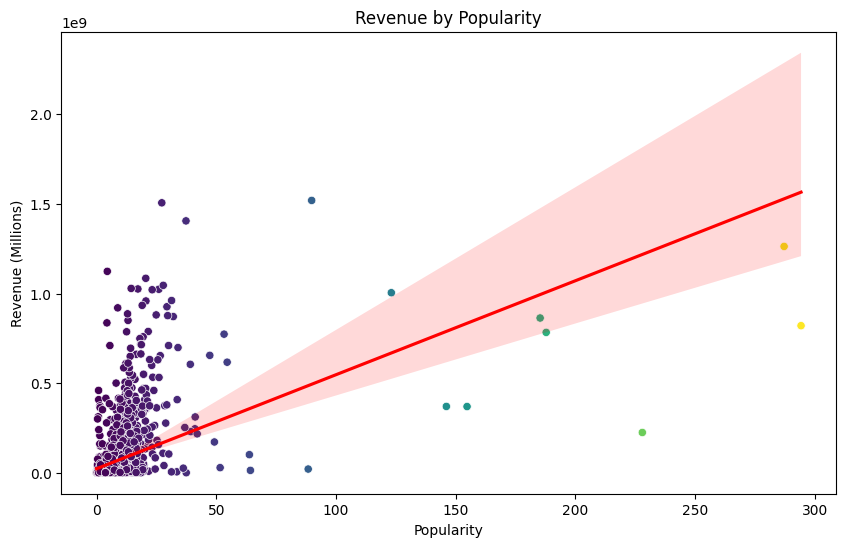

In [29]:
plt.figure(figsize=(10, 6))

# Scatter plot
sb.scatterplot(data=train, x='popularity', y='revenue', hue='popularity', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='popularity', y='revenue', scatter=False, color='red')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Revenue (Millions)')

# Loại bỏ chú thích
plt.legend().remove()

# Hiển thị biểu đồ
plt.show()

In [30]:
highest_popularity_movie = train['popularity'].max()

# In tên phim
print(train[train['popularity'] == highest_popularity_movie]['title'].iloc[0],train[train['popularity'] == highest_popularity_movie]['revenue'].iloc[0] )

Wonder Woman 820580447


                           title  runtime
3828  Jails, Hospitals & Hip-Hop     90.0


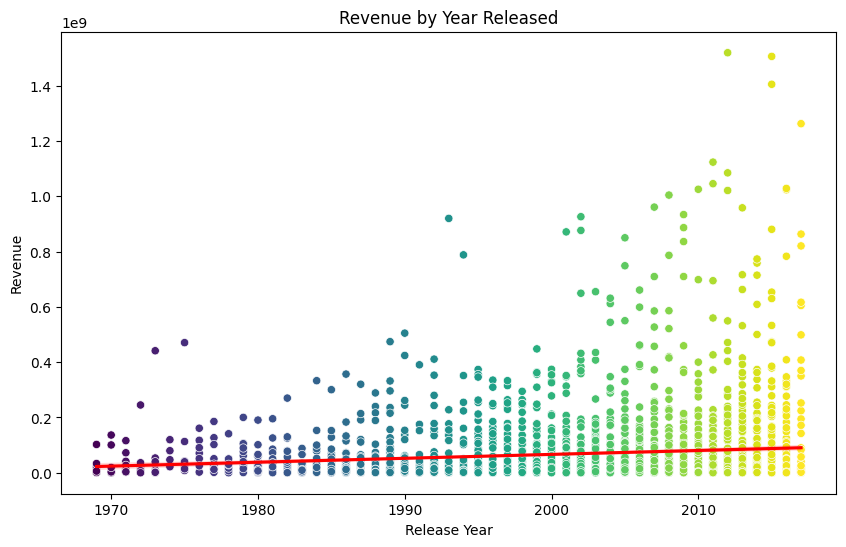

In [31]:
na_rows = full_data['release_date'].isnull()
print(full_data[na_rows][['title', 'runtime']])

# Sửa giá trị release_date tại hàng 3829 thành '3/20/01'
full_data.at[3829, 'release_date'] = '3/20/01'

# Chuyển đổi release_date sang định dạng datetime và lấy thông tin năm, quý, tháng, tuần, ngày trong tuần
train['release_date_mod'] = pd.to_datetime(train['release_date'], errors='coerce', format='%m/%d/%y')
train['release_year'] = train['release_date_mod'].dt.year
train['release_quarter'] = train['release_date_mod'].dt.quarter
train['release_month'] = train['release_date_mod'].dt.month_name()
train['release_week'] = train['release_date_mod'].dt.isocalendar().week
train['release_day'] = train['release_date_mod'].dt.day_name()
train = train[train['release_year'] <= 2020]

full_data['release_date_mod'] = pd.to_datetime(full_data['release_date'], errors='coerce', format='%m/%d/%y')
full_data['year_released'] = full_data['release_date_mod'].dt.year
full_data['quarter_released'] = full_data['release_date_mod'].dt.quarter
full_data['month_released'] = full_data['release_date_mod'].dt.month_name()
full_data['week_released'] = full_data['release_date_mod'].dt.isocalendar().week
full_data['weekday_released'] = full_data['release_date_mod'].dt.day_name()
full_data = full_data[full_data['year_released'] <= 2020]

# Vẽ biểu đồ scatter plot và regression line theo năm
plt.figure(figsize=(10, 6))
sb.scatterplot(data=full_data.iloc[:3000], x='year_released', y='revenue', hue='year_released', palette='viridis')
sb.regplot(data=full_data.iloc[:3000], x='year_released', y='revenue', scatter=False, color='red')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Year Released')
plt.xlabel('Release Year')
plt.ylabel('Revenue')

# Hiển thị biểu đồ
plt.legend().remove()  # Loại bỏ chú thích màu sắc
plt.show()


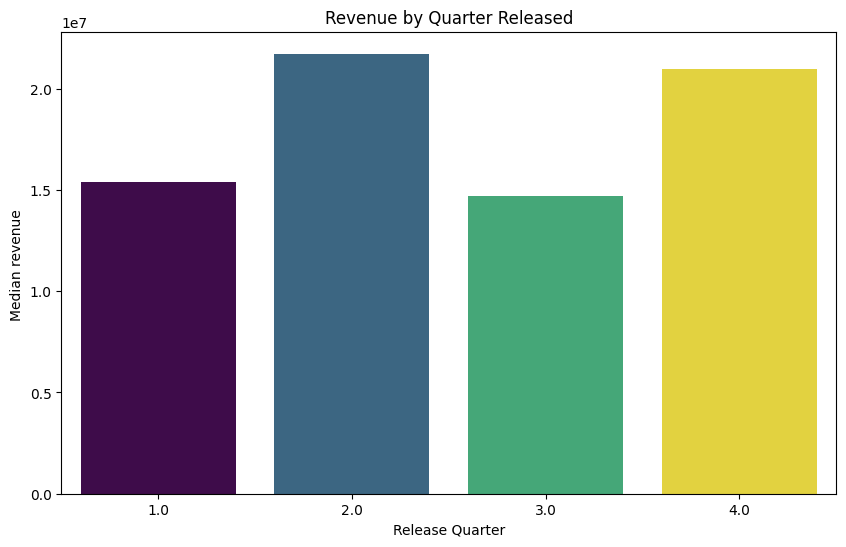

In [32]:
# Ở đây, thực hiện tính trung bình theo từng quý trước khi vẽ biểu đồ
quarterly_median = full_data.groupby('quarter_released')['revenue'].median().reset_index()

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
sb.barplot(data=quarterly_median, x='quarter_released', y='revenue', hue='quarter_released', palette='viridis', legend=False)

# Thiết lập các nhãn và tiêu đề
plt.title('Revenue by Quarter Released')
plt.xlabel('Release Quarter')
plt.ylabel('Median revenue ')

# Hiển thị biểu đồ
plt.show()


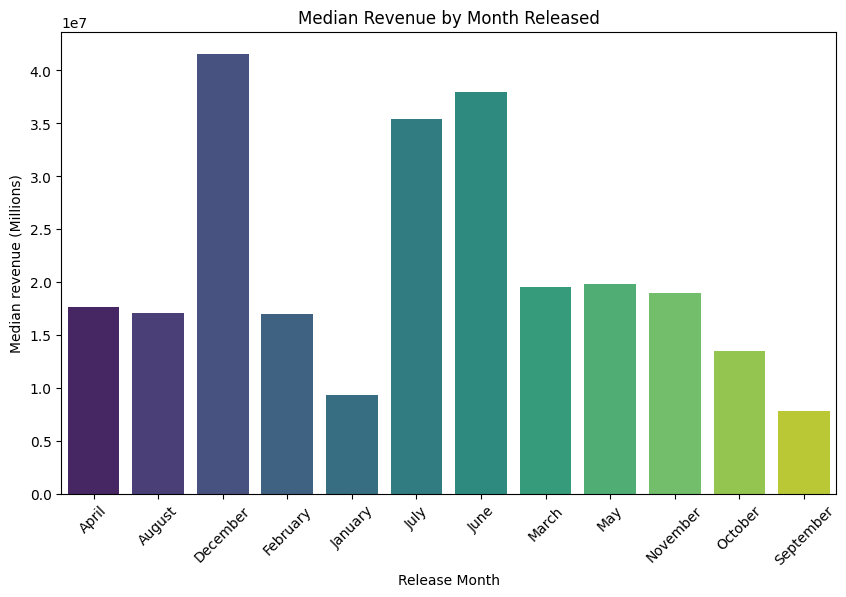

In [33]:
# Ở đây, thực hiện tính trung bình theo từng tháng trước khi vẽ biểu đồ
monthly_median = full_data.groupby('month_released')['revenue'].median().reset_index()

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
sb.barplot(data=monthly_median, x='month_released', y='revenue', hue='month_released', palette='viridis', legend=False)

# Thiết lập các nhãn và tiêu đề
plt.title('Median Revenue by Month Released')
plt.xlabel('Release Month')
plt.ylabel('Median revenue (Millions)')

# Xoay các nhãn trên trục x để chúng không trùng lên nhau
plt.xticks(rotation=45)

# Hiển thị biểu đồ
plt.show()

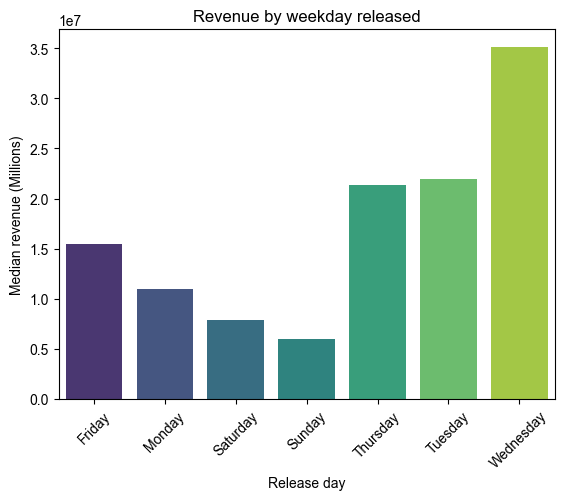

In [34]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
quarterly_median = full_data.groupby('weekday_released')['revenue'].median().reset_index()

weekday_plot = sb.barplot(data=quarterly_median, x='weekday_released', y='revenue', hue='weekday_released', palette='viridis', legend=True)
weekday_plot.set(title='Revenue by weekday released', xlabel='Release day', ylabel='Median revenue (Millions)')
ticks = weekday_plot.get_xticks()
positions = weekday_plot.get_xticklabels()

# Set the ticks explicitly
weekday_plot.set_xticks(ticks)
weekday_plot.set_xticklabels(weekday_plot.get_xticklabels(), rotation=45)  # Rotate x-axis labels
plt.legend().remove()  

plt.show()

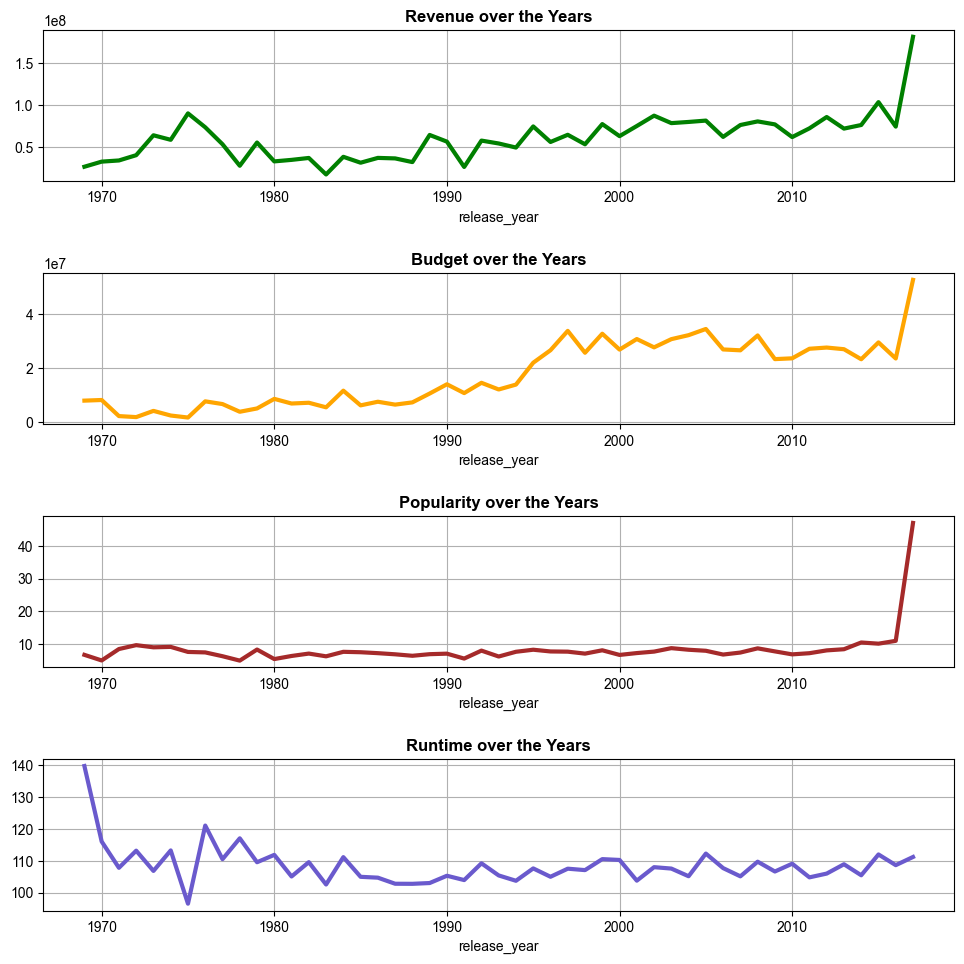

In [35]:
fig, ax = plt.subplots(4, 1, tight_layout=True)
plt.grid()

train.groupby('release_year')['revenue'].mean().plot(ax=ax[0], figsize=(10, 10), linewidth=3, color='green').set_title('Revenue over the Years', fontweight="bold")
ax[0].grid()

train.groupby('release_year')['budget'].mean().plot(ax=ax[1], figsize=(10, 10), linewidth=3, color='orange').set_title('Budget over the Years', fontweight="bold")
ax[1].grid()

train.groupby('release_year')['popularity'].mean().plot(ax=ax[2], figsize=(10, 10), linewidth=3, color='brown').set_title('Popularity over the Years', fontweight="bold")
ax[2].grid()

train.groupby('release_year')['runtime'].mean().plot(ax=ax[3], figsize=(10, 10), linewidth=3, color='slateblue').set_title('Runtime over the Years', fontweight="bold")
ax[3].grid()

fig.tight_layout(pad=2.0)
plt.show()

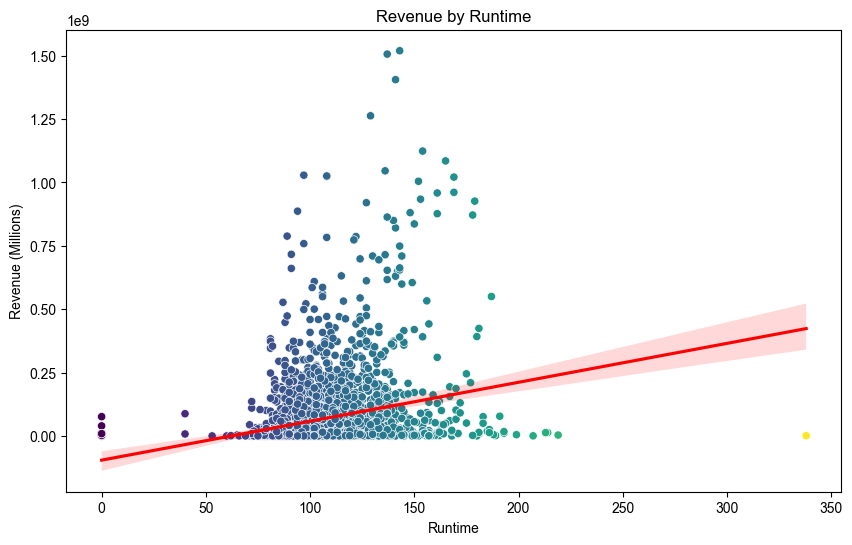

In [36]:
plt.figure(figsize=(10, 6))

# Scatter plot
sb.scatterplot(data=train, x='runtime', y='revenue', hue='runtime', palette='viridis')

# Đường hồi quy
sb.regplot(data=train, x='runtime', y='revenue', scatter=False, color='red')

# Cấu hình trục y
# plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1000', '$1500'])

# Thiết lập tiêu đề và nhãn trục
plt.title('Revenue by Runtime')
plt.xlabel('Runtime')
plt.ylabel('Revenue (Millions)')

# Hiển thị biểu đồ
plt.legend().remove()  # Loại bỏ chú thích
plt.show()


In [37]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.query('revenue >= 10000000')


In [38]:
test[test["release_date"].isnull()]
test.loc[test['release_date'].isnull()==True, 'release_date']= '5/1/00'
test[test["release_date"]== '5/1/00']

id belongs_to_collection     budget  \
828   3829                   NaN          0   
1731  4732                   NaN  103000000   

                                                 genres homepage    imdb_id  \
828                       [{'id': 18, 'name': 'Drama'}]      NaN  tt0210130   
1731  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...      NaN  tt0172495   

     original_language              original_title  \
828                 en  Jails, Hospitals & Hip-Hop   
1731                en                   Gladiator   

                                               overview  popularity  ...  \
828   Jails, Hospitals &amp; Hip-Hop is a cinematic ...    0.009057  ...   
1731  In the year 180, the death of emperor Marcus A...   23.186667  ...   

                                   production_countries release_date runtime  \
828                                                 NaN       5/1/00    90.0   
1731  [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...       5/1/00   155.0   

                              spoken_languages    status  \
828                                        NaN       NaN   
1731  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                                tagline  \
828   three worlds / two million voices / one genera...   
1731                                  A Hero Will Rise.   

                           title  \
828   Jails, Hospitals & Hip-Hop   
1731                   Gladiator   

                                               Keywords  \
828                                                 NaN   
1731  [{'id': 588, 'name': 'rome'}, {'id': 1394, 'na...   

                                                   cast  \
828                                                  []   
1731  [{'cast_id': 8, 'character': 'Maximus', 'credi...   

                                                   crew  
828                                                 NaN  
1731  [{'credit_id': '52fe4217c3a36847f800340d', 'de...  

[2 rows x 22 columns]

In [65]:
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
train["release_year"] = pd.to_datetime(train["release_date"]).dt.year.astype(int)
train["release_day"] = pd.to_datetime(train["release_date"]).dt.dayofweek.astype(int)
train["release_month"] = pd.to_datetime(train["release_date"]).dt.month.astype(int)
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')
test["release_year"] = pd.to_datetime(test["release_date"]).dt.year.astype(int)
test["release_day"] = pd.to_datetime(test["release_date"]).dt.dayofweek.astype(int)
test["release_month"] = pd.to_datetime(test["release_date"]).dt.month.astype(int)

In [66]:
train[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = train[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

test[['genres',
       'original_language', 
       'spoken_languages', 
       'status', 
       'production_countries', 
       'production_companies', 
       'cast',
       'crew']] = test[['genres',
         'original_language', 
         'spoken_languages',
         'status', 
         'production_countries',
         'production_companies', 
         'cast',
         'crew']].fillna("none")

In [67]:
train['runtime'] = train['runtime'].fillna(train['runtime'].mean())
test['runtime'] = test['runtime'].fillna(train['runtime'].mean())
train['runtime'].isnull().any()

False

In [68]:
train['log_revenue'] = np.log(train['revenue'])

In [69]:
for e in enumerate(test['genres'][:10]):
    print(e)

(0, "[{'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}]")
(1, "[{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}]")
(2, "[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]")
(3, "[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}, {'id': 9648, 'name': 'Mystery'}]")
(4, "[{'id': 36, 'name': 'History'}, {'id': 99, 'name': 'Documentary'}]")
(5, "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]")
(6, "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]")
(7, "[{'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}]")
(8, "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]")
(9, "[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]")


In [70]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [71]:
train.genres = train.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.spoken_languages = train.spoken_languages.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.cast = train.cast.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
train.crew = train.crew.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

test.genres = test.genres.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.spoken_languages = test.spoken_languages.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.cast = test.cast.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
test.crew = test.crew.map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))

train.crew.head()

0    Adam Blum,Allison Gordin,Andrew Panay,Annabell...
1    Bruce Green,Charles Minsky,Debra Martin Chase,...
2    Alicia Hadaway,Andy Ross,Barbara Harris,Ben Wi...
3                  Sujoy Ghosh,Sujoy Ghosh,Sujoy Ghosh
6    Adam Stern,Anders Villadsen,Andrew Fisher,Andy...
Name: crew, dtype: object

In [72]:
train['genres_count'] = train['genres'].str.count(',') + 1
train['spoken_languages_count'] = train['spoken_languages'].str.count(',') + 1
train['cast_count'] = train['cast'].str.count(',') + 1
train['crew_count'] = train['crew'].str.count(',') + 1

test['genres_count'] = test['genres'].str.count(',') + 1
test['spoken_languages_count'] = test['spoken_languages'].str.count(',') + 1
test['cast_count'] = test['cast'].str.count(',') + 1
test['crew_count'] = test['crew'].str.count(',') + 1
# test['genres_count']
print(train['spoken_languages'])
train['spoken_languages_count']

0                                               English
1                                               English
2                                               English
3                                        English,हिन्दी
6                                               English
                             ...                       
2993    English,Español,Français,Pусский,български език
2994                                            English
2997                                            English
2998                                            English
2999                                            English
Name: spoken_languages, Length: 1757, dtype: object


0       1
1       1
2       1
3       2
6       1
       ..
2993    5
2994    1
2997    1
2998    1
2999    1
Name: spoken_languages_count, Length: 1757, dtype: int64

In [73]:
train[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = train[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

train['status'] = train['status'].cat.codes
train['original_language'] = train['original_language'].cat.codes
train['production_companies'] = train['production_companies'].cat.codes
train['production_countries'] = train['production_countries'].cat.codes

test[['status', 
      'original_language', 
      'production_companies', 
      'production_countries']] = test[['status', 
               'original_language', 
               'production_companies',
               'production_countries']].astype('category')

test['status'] = test['status'].cat.codes
test['original_language'] = test['original_language'].cat.codes
test['production_companies'] = test['production_companies'].cat.codes
test['production_countries'] = test['production_countries'].cat.codes

train['production_countries']

0       178
1       178
2       178
3       121
6       157
       ... 
2993    178
2994    178
2997    178
2998    178
2999    178
Name: production_countries, Length: 1757, dtype: int16

In [74]:
train['budget'] = train['budget'].replace(0, train['budget'].mean())  
train['runtime'] = train['runtime'].replace(0, train['runtime'].mean())  

test['budget'] = test['budget'].replace(0, test['budget'].mean())  
test['runtime'] = test['runtime'].replace(0, test['runtime'].mean())  

In [75]:
y = train['log_revenue']
X = train.drop(['log_revenue', 'revenue'], axis=1)

In [76]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [77]:
feature_names = ['release_year', 'release_day', 'release_month', 'status', 'original_language',
                 'budget', 'popularity', 'genres_count', 'production_companies', 'production_countries',
                'spoken_languages_count', 'cast_count', 'crew_count', 'runtime']
feature_names_temp = ['revenue','release_year', 'release_day', 'release_month', 'status', 'original_language',
                 'budget', 'popularity', 'genres_count', 'production_companies', 'production_countries',
                'spoken_languages_count', 'cast_count', 'crew_count', 'runtime']
# Assigning the data corresponding to features in feature_names
X_train_full = X_train_full[feature_names]

X_valid_full = X_valid_full[feature_names]
train1 = train[feature_names_temp]
X_train_full.head()

release_year  release_day  release_month  status  original_language  \
323           1999            4              2       0                  3   
1179          1985            4              8       0                  3   
898           2006            4              9       0                  3   
2110          2010            4              2       0                 15   
2740          2016            2              9       0                  3   

            budget  popularity  genres_count  production_companies  \
323   9.000000e+07    9.112008             4                   798   
1179  3.547228e+07   12.372036             1                   840   
898   3.547228e+07    5.787334             6                  1149   
2110  3.000000e+06    1.036233             2                   871   
2740  9.000000e+07   13.809622             3                   254   

      production_countries  spoken_languages_count  cast_count  crew_count  \
323                    178                       1          14          75   
1179                   178                       2           9           9   
898                     32                       3          35          36   
2110                   118                       2          12          11   
2740                   178                       1          46          72   

      runtime  
323     100.0  
1179     87.0  
898      88.0  
2110    157.0  
2740    132.0

In [78]:
plt.figure(figsize=(10, 8))
sb.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

ValueError: could not convert string to float: "[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

<Figure size 1000x800 with 0 Axes>

In [82]:
rf_model = RandomForestRegressor(random_state=1)

# Fitting the model 
rf_model.fit(X_train_full, y_train)

RandomForestRegressor(random_state=1)

In [83]:
y_pred_rf = rf_model.predict(X_valid_full)
print(np.exp(y_pred_rf))

[4.97649410e+07 3.87434129e+07 2.26113848e+08 3.80080616e+08
 3.15133377e+07 4.16766728e+07 3.34250307e+07 2.30342116e+07
 3.73859672e+07 1.17689681e+08 2.24212186e+07 8.48562147e+07
 2.06691449e+08 1.08492258e+08 5.24862115e+07 4.83247842e+07
 1.00689037e+08 5.65857852e+07 4.60999024e+07 5.88367068e+07
 1.04198111e+08 4.28001931e+07 3.10953526e+07 4.72269927e+07
 4.45896288e+07 4.11969318e+07 2.86629792e+07 7.82381280e+07
 5.40408681e+07 3.42449814e+08 1.49135221e+08 4.54360780e+07
 6.75829908e+07 5.19724459e+08 9.59973575e+07 8.16070421e+07
 8.62388848e+07 3.76473999e+07 7.44958536e+07 3.33617262e+07
 8.56114963e+07 2.13654857e+07 2.04740211e+08 2.39993447e+07
 1.42193343e+08 4.21282107e+08 5.49710229e+07 2.59188207e+08
 1.44907470e+08 3.18355749e+07 4.71706447e+08 2.17052395e+08
 6.70768805e+07 3.09649798e+07 3.65656836e+07 3.08853995e+07
 3.43911238e+07 4.29337601e+07 1.07713292e+08 5.95367060e+07
 9.69420930e+07 2.20879611e+07 9.06100133e+07 4.87875211e+07
 3.90387693e+07 4.672057

In [84]:
# Create dataframe with predicted values
comp_df = pd.DataFrame(np.exp(y_pred_rf), columns=['predictions'])
# Add actual values to dataframe
y_valid_array = y_valid.values
comp_df['actual'] = np.exp(y_valid_array)
# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# # Add column that shows the percent difference between predicted and actual value
# comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100
# # Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
# comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df


predictions        actual    difference
0    4.976494e+07  1.405138e+07  3.571356e+07
1    3.874341e+07  7.651405e+07 -3.777064e+07
2    2.261138e+08  9.394577e+07  1.321681e+08
3    3.800806e+08  1.028571e+09 -6.484903e+08
4    3.151334e+07  3.264867e+07 -1.135335e+06
..            ...           ...           ...
347  2.040865e+07  1.144964e+07  8.959012e+06
348  2.697178e+08  1.637945e+08  1.059233e+08
349  8.333080e+07  1.000763e+08 -1.674555e+07
350  3.526022e+07  5.600000e+07 -2.073978e+07
351  5.596991e+07  1.300000e+07  4.296991e+07

[352 rows x 3 columns]

In [85]:
from sklearn.metrics import mean_absolute_error
mae_rf = mean_absolute_error(y_pred_rf, y_valid)

print("Mean Absolute Error RF:" , mae_rf)
print('Root mean squared error RF: ', np.sqrt(mean_squared_error(y_valid, y_pred_rf)))


Mean Absolute Error RF: 0.5982680164018448
Root mean squared error RF:  0.7423141453164336


<Axes: >

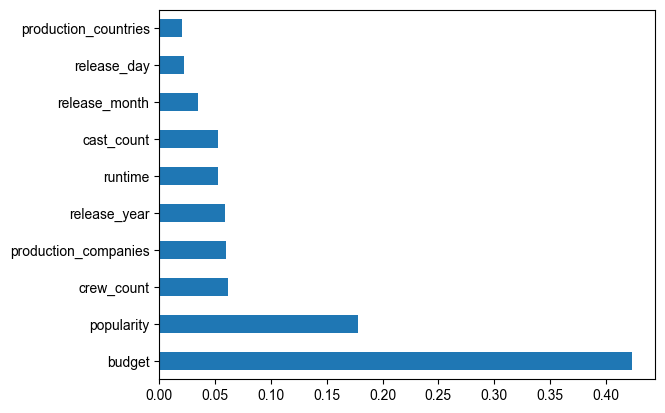

In [86]:
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train_full.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [87]:
X = train[feature_names]
X_test = test[feature_names]

In [88]:
final_model = RandomForestRegressor(random_state=1)

# Fitting the model 
final_model.fit(X, y)

RandomForestRegressor(random_state=1)

In [47]:
def len_var(df, col):
    '''
    Function to create new column containing number of values 
    in respective row of specified column
    Args: df = dataframe
          col = str; column header
    Returns: df = dataframe
    '''
    df['number_'+col] = df[col].apply(lambda x: len(x))

    return df


def add_top_30(dataset, col, topk):
    '''
    Function to add top 30 results from column headers as separate columns to 
    dataframe
    Args: dataset = dataframe 
          col = string; column name
          topk = list; top k values in column
    Returns: dataset = dataframe
    '''
    counter = 0
    for item in topk:
        header_name = str(item[0])+'_name'
        dataset[header_name] = dataset[col+'_temp'].apply(lambda x: 1 if item[0] in x else 0)

    return dataset


def clean(df, headers, list_top_30=[], train_set=True):
    '''
    Function to clean a dataframe
    Args: df = dataframe
          headers = list containing names of column headers that need 
                    to be converted from strings to dicts
          list_top_30 = list; default value is empty list; otherwise it can hold
                        list with lists of top 30 results from specific columns
          train = boolean; True by default; designates whether the dataframe is
                  a test or train dataset
    Returns: cleaned_df = cleaned dataframe
             total_top_k_var = list of top 30 results from particular columns
    '''
    
    # convert string format to variables in dict
    df = text_to_dict(df, headers)
    
    # convert data in dicts to list of strings
    df = formatting_dict_vars(df, headers)
    
    # dropping rows with 0s in budget column
    df = df[df['budget'] != 0]
    # drop rows with null values in numeric variables
    df = df.dropna(axis=0, how='any', subset=['release_date'])
    # dealing with missing values
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    most_common_genres = df['genres'].describe()['top']
    df['genres'] = df['genres'].apply(lambda x: most_common_genres if x == {} else x)
    
    # one-hot encode genres
    one_hot = df['genres_temp'].str.get_dummies(sep=',')

    df = df.join(one_hot)
    
    # add year
    df['release_year'] = df['release_date'].map(lambda x: str(19) + x[-2:] if int(x[-2:]) > 17 else str(20) + x[-2:])
    df['release_year'] = df['release_year'].astype('int32')
    # add month
    df['release_month'] = df['release_date'].map(lambda x: int(x[:2]) if x[1] != '/' else int(x[:1]))
    # add week
    df['release_week'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').isocalendar()[1])
    # add weekday
    df['release_weekday'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%A'))

    # one-hot encode month variables
    one_hot_month = pd.get_dummies(df['release_month'], prefix='month')
    # one-hot-encode weekday variable
    one_hot_weekday = pd.get_dummies(df['release_weekday'], prefix='weekday')
    
    df = df.join(one_hot_month)
    df = df.join(one_hot_weekday)

    # add column with 1 if movie belongs to any collection and 0 if it does not belong to any collection
    df['collection'] = df['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

    # add column for number of production companies
    df = len_var(df, 'production_companies')        
    # add column for number of production countries
    df = len_var(df, 'production_countries')
    # add column for revenue depending on number of languages
    df = len_var(df, 'spoken_languages')
    
    # Add column for existence of tag line
    df['tagline_exists'] = df['tagline'].apply(lambda x: 1 if x != 0 else 0)

    # Add column for length of tag line
    df['tagline'].fillna(0, inplace=True)
    df['tagline_length'] = df['tagline'].apply(lambda x: len(x) if x != 0 else 0)
    
    # Add column for length of title
    df['title'].fillna(0, inplace=True)
    df['title_length'] = df['title'].apply(lambda x: len(x) if x != 0 else 0)
    
    # add budget-year-ratio
    df['release_year'] = df['release_year'].astype('int32')
    df['budget_year_ratio'] = round(df['budget']/df['release_year'], 2)
    
    # add top thirty values as columns for below features
    top_30_vars = ['cast', 'crew', 'Keywords', 'production_companies', 'production_countries']
    if train_set:
        for var in top_30_vars:
            top_k_var = total_count(df, var)
            list_top_30.append(top_k_var)
            cleaned_df = add_top_30(df, var, top_k_var)
    else:
        for i in range(len(top_30_vars)):
            cleaned_df = add_top_30(df, top_30_vars[i], list_top_30[i])
    
    col_list = ['belongs_to_collection', 'belongs_to_collection_temp', 'genres', 'genres_temp', 'spoken_languages', 
                'spoken_languages_temp', 'production_companies', 'production_companies_temp', 'production_countries', 
                'production_countries_temp', 'Keywords', 'Keywords_temp', 'cast', 'cast_temp', 'crew', 'crew_temp', 'homepage', 
                'original_language', 'original_title', 'status', 'poster_path', 'release_date', 'release_month',
                'release_weekday', 'id', 'imdb_id', 'overview', 'tagline']
    
    for item in col_list:
        cleaned_df.drop(item, axis=1, inplace=True)
    
    # Reset the index so I will be able to match the revenue, title and budget to the rows later on
    cleaned_df = cleaned_df.reset_index()
    
    return cleaned_df, list_top_30
    

In [48]:
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

df_train, list_top_30 = clean(train, headers)

df_test, _ = clean(test, headers, list_top_30=list_top_30, train_set=False)

C:\Users\admin\AppData\Local\Temp\ipykernel_16032\3884170358.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col+'_temp'].apply(lambda x: 1 if item[0] in x else 0)
C:\Users\admin\AppData\Local\Temp\ipykernel_16032\3884170358.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col+'_temp'].apply(lambda x: 1 if item[0] in x else 0)
C:\Users\admin\AppData\Local\Temp\ipykernel_16032\3884170358.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [49]:
missing_from_test = [x for x in df_train.columns if x not in df_test.columns]
print('Missing from df_test:', missing_from_test)
for missing in missing_from_test:
    if missing != 'revenue':
        df_train.drop(missing, axis=1, inplace=True)


Missing from df_test: ['revenue', 'TV Movie']


In [50]:
train_revenue = df_train['revenue']
train_features_with_title = df_train.drop('revenue', axis=1)

# Drop the title variable and old index from the train_features_with_title dataframe
train_features = train_features_with_title.drop(['title', 'index'], axis=1)

# Save test dataframe that contains title variable
test_title = df_test[:]
# Drop title variable and old index from df_test
df_test = df_test.drop(['title', 'index'], axis=1)

In [51]:
# Transform budget and popularity variables
numeric_vars = ['budget', 'popularity']
train_features[numeric_vars] = train_features[numeric_vars].apply(lambda x: np.log(x + 1))
df_test[numeric_vars] = df_test[numeric_vars].apply(lambda x: np.log(x + 1)) 
train_revenue_log = train_revenue.apply(lambda x: np.log(x + 1))

# Convert arrays back to dataframes
train_features_minmax = pd.DataFrame(data = train_features)
df_test_minmax = pd.DataFrame(data = df_test)
train_revenue_minmax = pd.DataFrame(data = train_revenue_log)

# Scaling all datapoints between 0 and 1            
scaler = MinMaxScaler()
scaler.fit(train_features_minmax)
train_features_minmax = scaler.transform(train_features_minmax)
df_test_minmax = scaler.transform(df_test_minmax)

scaler_revenue = MinMaxScaler()
scaler_revenue.fit(train_revenue_minmax)
train_revenue_minmax = scaler_revenue.transform(train_revenue_minmax)

# Convert arrays back to dataframes
train_features_df = pd.DataFrame(data = train_features_minmax, columns = train_features.columns)
test_features_df = pd.DataFrame(data = df_test_minmax, columns = df_test.columns)
train_revenue_df = pd.DataFrame(data = train_revenue_minmax, columns = ['revenue'])
train_features_df['budget']

0       0.826827
1       0.881900
2       0.751017
3       0.697949
4       0.797470
          ...   
2183    0.695058
2184    0.903170
2185    0.907369
2186    0.884459
2187    0.874895
Name: budget, Length: 2188, dtype: float64

In [52]:
X_train, X_cross, y_train, y_cross = train_test_split(train_features_df, 
                                                      train_revenue_df, 
                                                      test_size = 0.2,
                                                      random_state = 42)

In [53]:
rf_model = RandomForestRegressor(random_state=1)

# Fitting the model 
rf_model.fit(X_train, y_train)

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=1)

In [54]:
y_pred_rf = rf_model.predict(X_cross)
print(np.expm1(scaler_revenue.inverse_transform(y_pred_rf.reshape(-1,1))))

[[2.19064205e+07]
 [1.66863268e+08]
 [1.26921985e+08]
 [2.81690583e+06]
 [8.05268287e+07]
 [3.89317640e+06]
 [1.12102450e+08]
 [3.47000617e+08]
 [1.76633146e+07]
 [2.06218521e+08]
 [1.48265926e+08]
 [6.02137616e+05]
 [1.40935212e+08]
 [4.18162869e+07]
 [3.19318385e+07]
 [1.83261551e+06]
 [7.84941477e+07]
 [1.94966585e+06]
 [8.52617213e+06]
 [1.03379171e+08]
 [1.07384822e+06]
 [1.02254062e+07]
 [5.67825234e+06]
 [8.21800985e+07]
 [1.14336030e+06]
 [8.72119597e+07]
 [9.05866413e+06]
 [1.98978044e+06]
 [9.59271810e+06]
 [1.32490828e+06]
 [3.65816610e+07]
 [1.61621278e+08]
 [3.02283624e+07]
 [3.04760811e+07]
 [1.56324035e+07]
 [1.48803859e+07]
 [3.48354674e+07]
 [1.53994812e+07]
 [2.18353591e+06]
 [5.07908585e+07]
 [7.71378181e+06]
 [2.38145236e+05]
 [2.27219281e+08]
 [3.98941232e+07]
 [2.88760021e+07]
 [4.42232902e+07]
 [2.15504094e+07]
 [3.33147078e+07]
 [5.30650922e+06]
 [5.19844280e+07]
 [7.77317160e+07]
 [7.44558072e+07]
 [3.37135553e+07]
 [3.86009189e+06]
 [8.79670514e+06]
 [8.761210

In [55]:
# Create dataframe with predicted values
comp_df = pd.DataFrame(np.expm1(scaler_revenue.inverse_transform(y_pred_rf.reshape(-1,1))),columns=['predictions'])
# Add actual values to dataframe
y_valid_array = y_valid.values
comp_df['actual'] = np.expm1(scaler_revenue.inverse_transform(y_cross))
# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100
# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 50 else 'bad')
comp_df
# okay_count = comp_df['okay'].value_counts()['okay']
# print(okay_count)

NameError: name 'y_valid' is not defined

In [ ]:
def len_var(df, col):
    '''
    Function to create new column containing number of values 
    in respective row of specified column
    Args: df = dataframe
          col = str; column header
    Returns: df = dataframe
    '''
    df['number_'+col] = df[col].apply(lambda x: len(x))

    return df


def add_top_30(dataset, col, topk):

    counter = 0
    for item in topk:
        header_name = str(item[0])+'_name'
        dataset[header_name] = dataset[col+'_temp'].apply(lambda x: 1 if item[0] in x else 0)

    return dataset


def clean(df, headers, list_top_30=[], train_set=True):

    
    # convert string format to variables in dict
    df = text_to_dict(df, headers)
    
    # convert data in dicts to list of strings
    df = formatting_dict_vars(df, headers)
    
    # dropping rows with 0s in budget column
    df = df[df['budget'] != 0]
    # drop rows with null values in numeric variables
    df = df.dropna(axis=0, how='any', subset=['release_date'])
    # dealing with missing values
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    most_common_genres = df['genres'].describe()['top']
    df['genres'] = df['genres'].apply(lambda x: most_common_genres if x == {} else x)
    
    # one-hot encode genres
    one_hot = df['genres_temp'].str.get_dummies(sep=',')

    df = df.join(one_hot)
    
    # add year
    df['release_year'] = df['release_date'].map(lambda x: str(19) + x[-2:] if int(x[-2:]) > 17 else str(20) + x[-2:])
    df['release_year'] = df['release_year'].astype('int32')
    # add month
    df['release_month'] = df['release_date'].map(lambda x: int(x[:2]) if x[1] != '/' else int(x[:1]))
    # add week
    df['release_week'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').isocalendar()[1])
    # add weekday
    df['release_weekday'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%A'))

    # one-hot encode month variables
    one_hot_month = pd.get_dummies(df['release_month'], prefix='month')
    # one-hot-encode weekday variable
    one_hot_weekday = pd.get_dummies(df['release_weekday'], prefix='weekday')
    
    df = df.join(one_hot_month)
    df = df.join(one_hot_weekday)

    # add column with 1 if movie belongs to any collection and 0 if it does not belong to any collection
    df['collection'] = df['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

    # add column for number of production companies
    df = len_var(df, 'production_companies')        
    # add column for number of production countries
    df = len_var(df, 'production_countries')
    # add column for revenue depending on number of languages
    df = len_var(df, 'spoken_languages')
    
    # Add column for existence of tag line
    df['tagline_exists'] = df['tagline'].apply(lambda x: 1 if x != 0 else 0)

    # Add column for length of tag line
    df['tagline'].fillna(0, inplace=True)
    df['tagline_length'] = df['tagline'].apply(lambda x: len(x) if x != 0 else 0)
    
    # Add column for length of title
    df['title'].fillna(0, inplace=True)
    df['title_length'] = df['title'].apply(lambda x: len(x) if x != 0 else 0)
    
    # add budget-year-ratio
    df['release_year'] = df['release_year'].astype('int32')
    df['budget_year_ratio'] = round(df['budget']/df['release_year'], 2)
    
    # add top thirty values as columns for below features
    top_30_vars = ['cast', 'crew', 'Keywords', 'production_companies', 'production_countries']
    if train_set:
        for var in top_30_vars:
            top_k_var = total_count(df, var)
            list_top_30.append(top_k_var)
            cleaned_df = add_top_30(df, var, top_k_var)
    else:
        for i in range(len(top_30_vars)):
            cleaned_df = add_top_30(df, top_30_vars[i], list_top_30[i])
    
    col_list = ['belongs_to_collection', 'belongs_to_collection_temp', 'genres', 'genres_temp', 'spoken_languages', 
                'spoken_languages_temp', 'production_companies', 'production_companies_temp', 'production_countries', 
                'production_countries_temp', 'Keywords', 'Keywords_temp', 'cast', 'cast_temp', 'crew', 'crew_temp', 'homepage', 
                'original_language', 'original_title', 'status', 'poster_path', 'release_date', 'release_month',
                'release_weekday', 'id', 'imdb_id', 'overview', 'tagline']
    
    for item in col_list:
        cleaned_df.drop(item, axis=1, inplace=True)
    
    # Reset the index so I will be able to match the revenue, title and budget to the rows later on
    cleaned_df = cleaned_df.reset_index()
    
    return cleaned_df, list_top_30
    

In [ ]:
 # read in data
import pandas as pd

train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

df_train, list_top_30 = clean(train, headers)
df_train1, list_top_30 = clean(train, headers)

df_test, _ = clean(test, headers, list_top_30=list_top_30, train_set=False)


In [ ]:
missing_from_test = [x for x in df_train.columns if x not in df_test.columns]
print('Missing from df_test:', missing_from_test)
for missing in missing_from_test:
    if missing != 'revenue':
        df_train.drop(missing, axis=1, inplace=True)

In [ ]:
# Separate revenue variable from df_train
train_revenue = df_train['revenue']
train_features_with_title = df_train.drop('revenue', axis=1)

# Drop the title variable and old index from the train_features_with_title dataframe
train_features = train_features_with_title.drop(['title', 'index'], axis=1)

# Save test dataframe that contains title variable
test_title = df_test[:]
# Drop title variable and old index from df_test
df_test = df_test.drop(['title', 'index'], axis=1)


In [56]:
# Transform budget and popularity variables
numeric_vars = ['budget', 'popularity']
train_features[numeric_vars] = train_features[numeric_vars].apply(lambda x: np.log(x + 1))
df_test[numeric_vars] = df_test[numeric_vars].apply(lambda x: np.log(x + 1)) 
train_revenue_log = train_revenue.apply(lambda x: np.log(x + 1))

# Convert arrays back to dataframes
train_features_minmax = pd.DataFrame(data = train_features)
df_test_minmax = pd.DataFrame(data = df_test)
train_revenue_minmax = pd.DataFrame(data = train_revenue_log)

# Scaling all datapoints between 0 and 1            
scaler = MinMaxScaler()
scaler.fit(train_features_minmax)
train_features_minmax = scaler.transform(train_features_minmax)
df_test_minmax = scaler.transform(df_test_minmax)

scaler_revenue = MinMaxScaler()
scaler_revenue.fit(train_revenue_minmax)
train_revenue_minmax = scaler_revenue.transform(train_revenue_minmax)

# Convert arrays back to dataframes
train_features_df = pd.DataFrame(data = train_features_minmax, columns = train_features.columns)
test_features_df = pd.DataFrame(data = df_test_minmax, columns = df_test.columns)
train_revenue_df = pd.DataFrame(data = train_revenue_minmax, columns = ['revenue'])


In [59]:
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size = 0.2,
                                                              random_state = 42)

In [60]:
# Create LGB Dataset for train set and eval set
train_set_lgb = lgb.Dataset(X_train_part, y_train_part)
valid_sets_lgb = [lgb.Dataset(X_val, y_val)]

# Define the initial parameters to use (default values)
parameters_lgb = {'metric' : 'rmse', # default blank
                  'max_depth': -1, 
                  'learning_rate': 0.1, 
                  'max_bin': 255, 
                  'num_leaves': 31, 
                  'feature_fraction': 1.0,
                  'lambda_l1': 0}

# Define the variations of each parameter to be checked
max_depth = [-1, 5, 10]
learning_rate = [0.1, 0.05, 0.001]
max_bin = [255, 350, 400]
num_leaves = [20, 31, 40]
feature_fraction = [0.5, 0.7, 1]
lambda_l1 = [0, 0.2, 0.4]


In [61]:
def grid_search_lgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on LightGBM model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_lgb[param1] = val1
            parameters_lgb[param2] = val2
            cv_results_lgb = lgb.cv(params = parameters_lgb,
                                    train_set=train_set_lgb,
                                    num_boost_round=1000,
                                    early_stopping_rounds=15,
                                    nfold=5,
                                    stratified=False)
            
            best_rmse = min(cv_results_lgb['rmse-mean']) 
            boost_rounds = cv_results_lgb['rmse-mean'].index(best_rmse)
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRSME {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))
        

In [62]:
grid_search_lgb('learning_rate', 'max_depth', learning_rate, max_depth)


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise 

In [63]:
# Update learning_rate and max_depth
parameters_lgb['learning_rate'] = 0.05
parameters_lgb['max_depth'] = 5

# Gridsearch through max_bin and num_leaves values for LightGBM model
grid_search_lgb('max_bin', 'num_leaves', max_bin, num_leaves)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `forc

LightGBMError: Cannot change max_bin after constructed Dataset handle.

In [64]:
# Update learning_rate and max_depth
parameters_lgb['learning_rate'] = 0.05
parameters_lgb['max_depth'] = 5
# Update max_bin and num_leaves
parameters_lgb['max_bin'] = 255
parameters_lgb['num_leaves'] = 31

# Gridsearch through feature_fraction and lambda_l1 values for LightGBM model
grid_search_lgb('feature_fraction', 'lambda_l1', feature_fraction, lambda_l1)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 113
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train se

In [65]:
# LightGBM
# Details on parameters tuning here: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# Example of LGBM tuning https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823

clf_lgb = lgb.train(params = parameters_lgb,
                    train_set = lgb.Dataset(X_train_part, y_train_part),
                    num_boost_round = 10000,
                    valid_sets = [lgb.Dataset(X_val, y_val)],
                    early_stopping_rounds = 500,
                    verbose_eval = 10)

y_pred = clf_lgb.predict(X_cross)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 113
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.783459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scor

In [66]:
pickle.dump(clf_lgb, open('lightgbm.sav', 'wb'))


In [67]:
# Print different metrics to evaluate LightGB model
# print('Root mean squared error for LightGBM algorithm is: ', np.sqrt(mean_squared_error(y_cross, y_pred)))

# Inverse transform the scaled revenue data from LightGBM model
absolute_y_cross = np.expm1(scaler_revenue.inverse_transform(y_cross))
absolute_y_pred = np.expm1(scaler_revenue.inverse_transform(y_pred.reshape(-1,1)))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))


Absolute root mean squared error:  112807413.56535815


In [75]:
# Create dataframe with predicted values
comp_df = pd.DataFrame(np.expm1(scaler_revenue.inverse_transform(y_pred.reshape(-1,1))), columns=['predictions'])

# Add actual values to dataframe
comp_df['actual'] = np.expm1(scaler_revenue.inverse_transform(y_cross))

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# # Add column that shows the percent difference between predicted and actual value
# comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# # # Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
# comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
# Đặt cài đặt hiển thị của pandas để show toàn bộ dữ liệu
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Hiển thị DataFrame comp_df
print(comp_df)



      predictions        actual    difference
0    3.205613e+07  7.318072e+07 -4.112459e+07
1    1.327399e+08  1.637945e+08 -3.105461e+07
2    1.038747e+08  1.523686e+08 -4.849389e+07
3    2.839659e+06  2.034216e+07 -1.750250e+07
4    8.415640e+07  1.555634e+07  6.860006e+07
5    3.109645e+06  5.563504e+07 -5.252539e+07
6    8.406970e+07  7.490134e+07  9.168358e+06
7    3.858031e+08  1.730000e+08  2.128031e+08
8    1.311853e+07  1.280331e+07  3.152291e+05
9    2.216292e+08  2.061725e+08  1.545668e+07
10   1.238865e+08  1.039515e+08  1.993503e+07
11   3.108582e+05  2.640850e+06 -2.329992e+06
12   1.341752e+08  1.304829e+08  3.692373e+06
13   2.743701e+07  1.243478e+07  1.500223e+07
14   2.861203e+07  1.941299e+07  9.199041e+06
15   3.939862e+06  2.605500e+04  3.913807e+06
16   1.041904e+08  2.812867e+07  7.606171e+07
17   2.925869e+06  2.380000e+07 -2.087413e+07
18   6.536373e+06  1.020921e+06  5.515452e+06
19   8.118368e+07  1.793795e+08 -9.819585e+07
20   2.622527e+06  7.900000e+06 -5

In [74]:
okay_count = comp_df[comp_df['okay'] == 'okay'].shape[0]

print(okay_count)

66


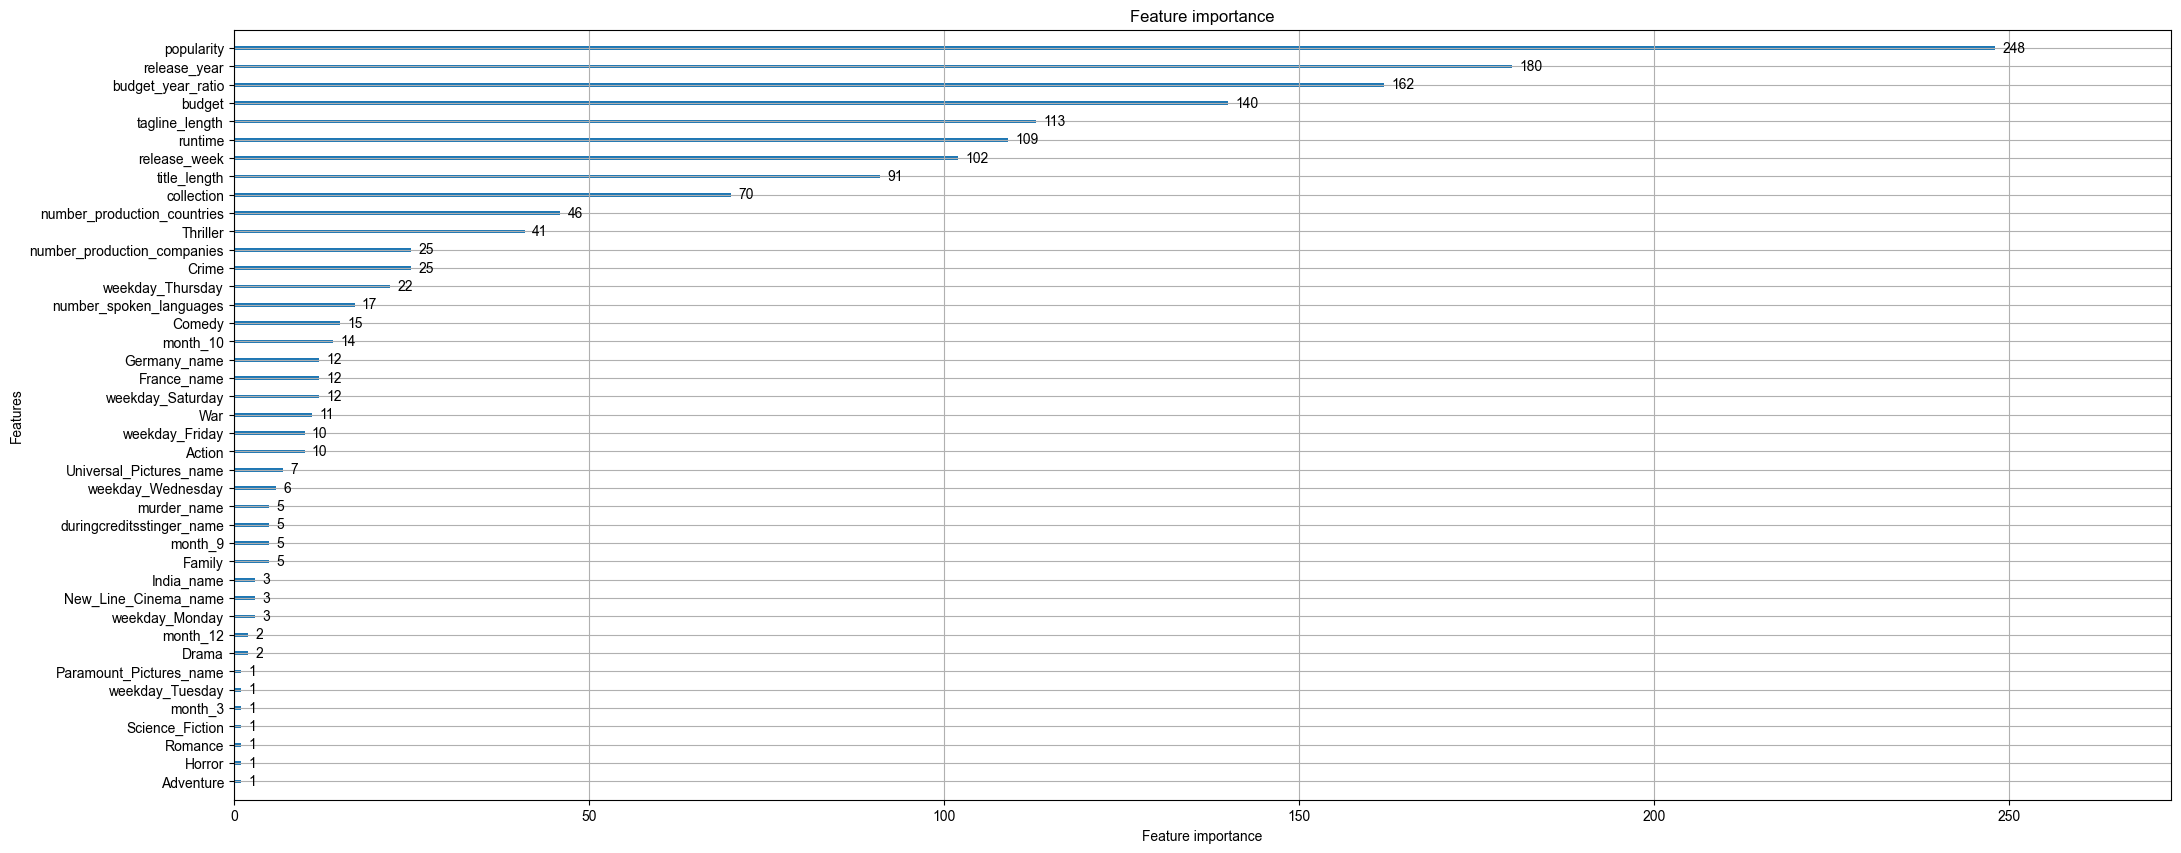

In [76]:
# Plot the feature importance of the LightGBM model
fig, ax = plt.subplots(figsize=(25,10))
lgb.plot_importance(clf_lgb, ax=ax, max_num_features=50);


In [ ]:
def flop_success_preds(title_df, test_df, y_pred, train_set=True, label_df=[]):

    title_budget_df = title_df[['budget', 'title']]
    
    title_budget_df = title_budget_df.loc[test_df.index,:]

    if train_set:
        title_budget_df = title_budget_df.join(label_df, how='left')
        
    y_pred = pd.DataFrame(np.expm1(scaler_revenue.inverse_transform((y_pred).reshape(-1,1))).astype('int32'), columns=['preds'])

    title_budget_df = title_budget_df.reset_index()

    flop_success_df = title_budget_df.join(y_pred)

    flop_success_df['profit_preds'] = (1/2) * flop_success_df['preds'] - flop_success_df['budget']

    flop_success_df['cat_profit_preds'] = flop_success_df['profit_preds'].apply(lambda x: 'Yes' if x > 0 else 'No')

    if train_set:
        flop_success_df['profit_actual'] = (1/2) * flop_success_df['revenue'] - flop_success_df['budget']
        flop_success_df['cat_profit_actual'] = flop_success_df['profit_actual'].apply(lambda x: 'Yes' if x > 0 else 'No')
    
    return flop_success_df
    
    

In [ ]:
flop_success_X_train = flop_success_preds(train_features_with_title, 
                                          X_train, 
                                          y_pred_lgb, 
                                          train_set=True, 
                                          label_df=train_revenue)
flop_success_X_train

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    '''
    Function to plot a confusion matrix and the accuracy of the predictions
    Args: y_test = numpy array or pandas series; categorical values of actual flop/success
          y_pred = numpy array or pandas series; categorical values of predicted flop/success
    Returns: None
    '''
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Convert confusion matrix to dataframe
    cm_df = pd.DataFrame(cm, index = ['Success', 'Flop'], columns = ['Success', 'Flop'])

    # Plot the confuction matrix
    plt.figure(figsize=(7, 6))
    sb.heatmap(cm_df, annot=True, fmt='d')

    plt.title('Flop and Success Predictions \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,
                                                                                      y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    
plot_confusion_matrix(flop_success_X_train['cat_profit_actual'], flop_success_X_train['cat_profit_preds'])


In [ ]:
correlation_matrix = df_train.corr()

sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
lgb.plot_importance(clf_lgb, ax=ax, max_num_features=50);

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

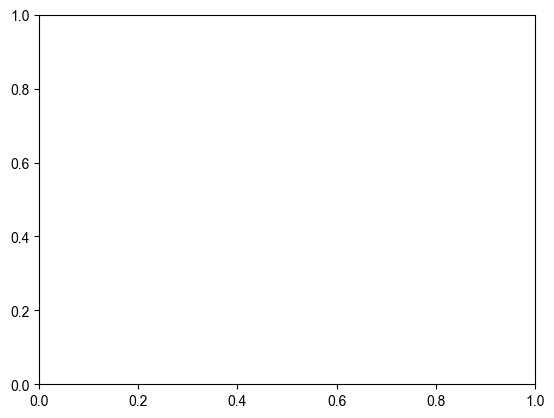

In [77]:
import matplotlib.pyplot as plt
ax = lgb.plot_tree(clf_lgb, tree_index=2)
plt.show()

In [2]:
from sklearn.linear_model import LinearRegression


In [3]:
model = LinearRegression()
y_predicted = model.predict(X_cross)


NameError: name 'X_cross' is not defined

In [6]:
import pandas as pd
train = pd.read_csv("train.csv", delimiter=',')

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok